In [1]:
Threads.nthreads()
begin
    using LinearAlgebra 
    using Plots
    using FFTW
    using FileIO
    using JLD2
    using DiffEqFlux
    using OrdinaryDiffEq
    using BlockArrays
    using LaTeXStrings
    using SparseArrays
    using BSON
    using Distances
    using DifferentialEquations
    using Optimization
    using OptimizationPolyalgorithms
    using Zygote
    using OptimizationOptimJL
    using OptimizationOptimisers
    using DiffEqSensitivity
    using DelimitedFiles
    using HDF5
    using InvertedIndices
    using Random
    using Statistics
    using LineSearches
    using CSV
    using DataFrames
    using ChainRulesCore
    using NPZ
    using StatsPlots
    using LaTeXStrings
end 

In [2]:
# Define the dimensions
num_geomIDs = 10  # number of geometries
num_waveIDs = 10  # number of waveforms

# Define the matrix to store the data
all_data = []

# Iterate over geomID and waveID
for geomID in 1:num_geomIDs
    for waveID in 0:num_waveIDs-1  # Adjust the range as needed
        filename = "/home/hunor/PhD/LANL/data/summer2024/case_$(geomID)_$(waveID)/averagedTo1DFrom0_case_$(geomID)_$(waveID).npy"
        try
            # Use np.load() to read data from the .npy file
            data = npzread(filename)
            push!(all_data, data)
        catch
            println("File not found: ", filename)
        end
    end
end

In [3]:
data_mat = permutedims(reduce((x, y) -> cat(x, y, dims=4), all_data),(2,3,4,1))
println("Size of 1D data matrix:",size(data_mat))
println("Shape: [timesteps,spatial locations,cases, variables]")
println("Variable order: flow rate, pressure*area, undef area, deformed area, radial displacement, wss")

Size of 1D data matrix:(100, 101, 100, 6)
Shape: [timesteps,spatial locations,cases, variables]
Variable order: flow rate, pressure*area, undef area, deformed area, radial displacement, wss


In [4]:
# define global variables
begin
    global dz = 0.04                  # x step
    global L = 4.00                   # total length
    global zspan = (0,L)              # end points of spatial integration for neural ODE momentum eqn
    global train_maxiters = 5         # number of internal iterations of learning (this is NOT the epochs)
    global learning_rate  = 0.01      # learning rate
    global dt = 0.01                  # time step, has to be smaller or equal to saveat
    global tcycles = 3                # cardiac cycles
    global T = tcycles - dt;          # total solution time
    global saveat = 0.01              # ground truth data time resolution
    global tsteps = 0.0:dt:T          # discretized time dimension
    global tspan = (0,T);             # end points of time integration for continuity eqn
end;

                 # total time

In [5]:
path_to_working_directory="/home/hunor/PhD/LANL/revision/"

# import auxiliary functions for training and numerical derivative calculations

include("$path_to_working_directory/src/numerical_derivatives.jl");
include("$path_to_working_directory/src/train_utils.jl");

In [6]:
#first order derivatives for time
∂t1_center = f1_secondOrder_central(size(tsteps)[1],dt);
∂t1_forward = f1_secondOrder_forward(size(tsteps)[1],dt);
∂t1_backward = f1_secondOrder_backward(size(tsteps)[1],dt);

# use central difference for the majority
∂t1 = ∂t1_center
# use forward and backward difference near the boundaries
∂t1[1,:]=∂t1_forward[1,:]
∂t1[end,:] = ∂t1_backward[end,:];

In [7]:
# Set the seed for reproducibility
Random.seed!(123)

total_waveforms = size(data_mat,3)

indices = 1:total_waveforms;

In [8]:
# Divide the shuffled indices into training and test sets
# This is done somewhat arbitrarily
test_indices_geom = [indices[91:100]];   # new stenosis blockage ratio
test_indices_wave = [indices[10:10:90]];  # new waveforms

# Convert StepRange objects to arrays
test_indices_geom = collect(test_indices_geom[1]);
test_indices_wave = collect(test_indices_wave[1]);

# Find indices not in test_indices_ex
shuffle_flag = false # flag to shuffle training data

# Set shuffling to false in inference mode to not mess up the plots
if shuffle_flag
    train_indices = shuffle(setdiff(indices, vcat(test_indices_wave, test_indices_geom)));
else
    train_indices = setdiff(indices, vcat(test_indices_wave, test_indices_geom));
end;

In [9]:
# select field variable ID
# 1 -flow rate, 2- pressure*area, 3- undef area, 4- deformed area, 5-radial displacement, 6-wss
pID = 1;

In [10]:
#define IC's for flow rate
u0 = data_mat[1,1:end,train_indices,pID];         # train
u01 = data_mat[1,1:end,1,pID];

# define test set for interpolation and extrapolation cases
u0_test_wave = data_mat[1,1:end,test_indices_wave,pID];     # new waveform
u0_test_geom = data_mat[1,1:end,test_indices_geom,pID];    # new stenosis blockage ratio

# ground truth flow rate data
ytrain2 = data_mat[:,1:end,train_indices,pID];    #train
ytrain21 = data_mat[:,1:end,1,pID];
# test flow rate data
ytest_wave = data_mat[:,1:end,test_indices_wave,pID];      # new waveform
ytest_geom = data_mat[:,1:end,test_indices_geom,pID];     # new stenosis blockage ratio

# inlet boundary conditions 
bc_flow = data_mat[:,1,train_indices,pID];        # train
bc_flow1 = bc_flow[:,1];

bc_flow_test_wave = data_mat[:,1,test_indices_wave,pID];    # new waveform
bc_flow_test_geom  = data_mat[:,1,test_indices_geom,pID];  # new stenosis blockage ratio

In [11]:
Nspace = size(u01,1)   # number of points in space
x = 0.0 : dz : L        # discretized spatial dimension 

# finite-difference schemes for spatial derivatives

#first order derivatives for space
∂x1_center = f1_secondOrder_central(Nspace,dz);
∂x1_forward = f1_secondOrder_forward(Nspace,dz);
∂x1_backward = f1_secondOrder_backward(Nspace,dz);

# use central difference for the majority
∂x1 = ∂x1_center
# use forward and backward difference near the boundaries
∂x1[1,:]=∂x1_forward[1,:]
∂x1[end,:] = ∂x1_backward[end,:]



#second order derivatives
∂x2_center = f2_secondOrder_central(Nspace,dz);
∂x2_forward = f2_secondOrder_forward(Nspace,dz);
∂x2_backward = f2_secondOrder_backward(Nspace,dz);

# use central difference for the majority
∂x2 = ∂x2_center;
# use forward and backward difference near the boundaries
∂x2[1,:]=∂x2_forward[1,:];
∂x2[end,:] = ∂x2_backward[end,:];

In [12]:
# create arrays with area data

aID = 4 # deformed area
# aID-1 = 3 is undeformed area

#ground truth data for area
Atrain_org = data_mat[:,1:end,train_indices,aID]; # ground-truth area

# undeformed area will initilize the model
Atrain = data_mat[:,1:end,train_indices,aID-1] # "undeformed area" for initalization
Atrain_undef = Atrain;
Atrain1 = data_mat[:,1:end,1,aID];

# the same areas will from be used for all 3 sets
Atest_wave_org = data_mat[:,1:end,test_indices_wave,aID]; # ground-truth area
Atest_wave =  data_mat[:,1:end,test_indices_wave,aID-1] #undeformed area for initalization
Atest_wave_undef = Atest_wave;

Atest_geom_org = data_mat[:,1:end,test_indices_geom,aID]; # ground-truth area
Atest_geom = data_mat[:,1:end,test_indices_geom,aID-1]; #undeformed area for initalization
Atest_geom_undef = Atest_geom;

In [13]:
N = size(bc_flow1,1) # number of temporal points
# Define the network architecture
# input will be Q and S
hidden_dim = 8 # neurons in the hidden layer
depth = 4 # number of hidden layers

function make_nn(length_in = 80, length_out = 1, nodes = 128, hid_lay = 3, act_fun = relu, act_fun_last = sigmoid)
    first_layer = Dense(length_in, nodes, act_fun, init = Flux.glorot_uniform)
    intermediate_layers = [Dense(nodes,nodes,act_fun, init = Flux.glorot_uniform) for _ in 1:hid_lay-1]
    last_layer = Dense(nodes, length_out, act_fun_last, init = Flux.glorot_uniform)

    return Chain(
        first_layer,
        intermediate_layers...,
        last_layer
    )
end
ann = make_nn(2*N,N,hidden_dim,depth,tanh,identity)

Chain(
  Dense(200 => 8, tanh),                # 1_608 parameters
  Dense(8 => 8, tanh),                  # 72 parameters
  Dense(8 => 8, tanh),                  # 72 parameters
  Dense(8 => 8, tanh),                  # 72 parameters
  Dense(8 => 100),                      # 900 parameters
)                   # Total: 10 arrays, 2_724 parameters, 11.266 KiB.

In [14]:
# flatten parameters in NN for learning.                
p, re = Flux.destructure(ann);
ps = deepcopy(p)
p_size = size(p,1);
println("Number of parameters in neural network for momentum equation: $p_size"); 

Number of parameters in neural network for momentum equation: 2724


In [15]:
# parameters for continuity equation                
p_cont = cat(ones(size(ytrain2[1,:,1])),zeros(size(ytrain2[1,:,1])),dims=1)
ps_cont = deepcopy(p_cont)
pcont_size = size(p_cont,1);
println("Number of parameters in p vector for continuity equation: $pcont_size"); 

Number of parameters in p vector for continuity equation: 202


In [16]:
fourier_params = vcat(ones(size(ytrain2)[2]), zeros(size(ytrain2)[2]));
Nf = 10; # Fourier-modes
z = LinRange(0, L, Nspace)  # Spatial grid
T_per = 1.0 # cardiac cycle length
t = LinRange(0, T_per-dt, N)  # Time grid for 1 periods
pfourier_size = size(fourier_params,1);
ω_n(n) = 2 * π * n / T_per # define frequency function

println("Number of parameters in p vector for Fourier-series fit: $pfourier_size "); 

Number of parameters in p vector for Fourier-series fit: 202 


In [17]:
# Define the function a(z) with parameters to be optimized
a(z, params) = params[1:Nspace]

b(z, params) = params[Nspace+1:end]

# Discrete Fourier coefficients for Q(z, t) using FFT
Q_n(Q_data) = fft(Q_data,2) / N

# Compute S_n(z) from Q_n(z) and a(z)
function S_n(z, Q_fft, params)
    S_fft = zeros(Complex{Float64}, size(Q_fft))
    for n in 1:Nf
        dQn_dz = ∂x1 * (Q_fft[:, n,:])
        S_fft[:, n,:] = - a(z,params).* dQn_dz / (1im * ω_n(n))
    end
    S_fft
end

# Define the MSE loss function to be minimized
function mse_loss(params, Q_data, S_data, S_0)
    Q_fft = Q_n(Q_data)
    S_fft = S_n(z, Q_fft, params)
    S_fft[:, 1,:] = S_0 - reshape(sum(S_fft[:, 2:end,:],dims=2),(size(S_fft,1),size(S_fft,3))) .+ b(z, params)  # Set the Fourier coefficient for n=0 using initial condition
    S_t = ifft(S_fft,2) * N
    

    loss = mean((real(S_t) - S_data).^2)
    loss
end

function S_optimized(Q_data, optimal_params, S_0)
    Q_fft = Q_n(Q_data)
    S_fft = S_n(z, Q_fft, optimal_params)
    S_fft[:, 1,:] = S_0 - reshape(sum(S_fft[:, 2:end,:],dims=2),(size(S_fft,1),size(S_fft,3))) .+ b(z, optimal_params)  # Set the Fourier coefficient for n=0 using initial condition
    S_t = ifft(S_fft, 2) * N
    S_t
end

S_optimized (generic function with 1 method)

In [18]:
# # Define time-dependent variables
function interpolate_variables(t, vector, dz, L)
    # t - dependent variable, could be time or space (z) too
    #      if t is time then use dt, if it's space use dz, same with T <--> L
    # vector - data vector with values at distinct t locations
    # dz - steps at which we have data in vector
    # L - (physical) length of t
    #
    # This function interpolates values such that we can access the values from vector
    # not just at the original data points but anywhere in between
    

    # Find the two closest points in vector
    #caculate the time index that's closest to time t

    t_index = Int(floor(t / dz)) + 1

    # calculate local time fraction between the grid points
    t_frac = (t - (t_index - 1) * dz) / dz

    # Perform linear interpolation between data points in vector
    # if we are at the last timesteps just copy the value cause t_index+1 will not exist
    if t == L
        vector_interp = vector[:,:,t_index]
        
    else
        vector_interp = (1 - t_frac) * vector[:,:,t_index] + t_frac * vector[:,:,t_index + 1]
    end
    
    # return the interpolated value of vector at time(space) = t
    return vector_interp
end

interpolate_variables (generic function with 1 method)

In [19]:
# parabolic flow profile constant
# https://simvascular.github.io/docs1DSimulation.html#solver
δ = 1/3;
# viscosity in CGS units
ν = 0.04;
# velocity profile constant
Nprof = -8*π*ν;

In [20]:
function learn_1DBlood(u, p, z, interp_func)
    # u -  field variable we are solving for (flow rate)
    # p - neural network parameters
    # z - dependent variable (z -space, or t - time)
    # interp_func - area values for interpolation as a function of z
    
    
    Φ = re(p)  # restructure flattened parameter vector into NN architecture.
    

    v = vcat(u,interp_func(z))   # concatenate Q and S
    return Φ(v)
end

# #define learning problem.
learn_1DBlood_prob(u01,zspan) =  ODEProblem((u, p, z) -> learn_1DBlood(u, p, z, bc_left_func), u01, zspan, p)

learn_1DBlood_prob (generic function with 1 method)

In [21]:
function learn_1DBlood_continuity(u, p, t, interp_func)
    # u -  field variable we are solving for (flow rate)
    # p - learnable parameters parameters
    # t - dependent variable (z -space, or t - time)
    # interp_func - flow rate values for interpolation as a function of t
    
    flow_rate = interp_func(t) #flow rate at the interpolated timestep
    # -a(z)*dQ/dz+b(z)
    return -p[1:size(∂x1,1)] .* (∂x1 * flow_rate) .+ p[size(∂x1,1)+1:2*size(∂x1,1)]
end

learn_1DBlood_continuity (generic function with 1 method)

In [22]:
ode_solver = "Tsit5"
output_dir = "/home/hunor/PhD/LANL/revision/dQdz_FourierSeries_Final"
working_dir = output_dir


prob = ODEProblem((u, p, z) -> learn_1DBlood(u, p, z,bc_left_func), bc_flow1, zspan, p) ;
function predict(θ,prob)
    if ode_solver == "Tsit5"
        Array(solve(prob,Tsit5(),p=θ,dt=dz,saveat=dz,adaptive=true))
    elseif ode_solver == "RK4"
        Array(solve(prob,RK4(),p=θ,dt=dz/10,saveat=dz,adaptive=false,alg_hints=[:stiff]))
    elseif ode_solver == "Rosenbrock23"
        Array(solve(prob,Rosenbrock23(),p=θ,dt=dz/10,saveat=dz,adaptive=false,alg_hints=[:stiff]))
    end
end 

predict (generic function with 1 method)

In [23]:
prob_S = ODEProblem((u, p, z) -> learn_1DBlood_continuity(u, p, t,interp_func), Atrain1[1,:], tspan, p) ;
function predict_S(θ,prob_S)
    if ode_solver == "Tsit5"
        Array(solve(prob_S,Tsit5(),p=θ,dt=dt,saveat=dt,adaptive=false))
    elseif ode_solver == "RK4"
        Array(solve(prob_S,RK4(),p=θ,dt=dt/10,saveat=dt,adaptive=false,alg_hints=[:stiff]))
    elseif ode_solver == "Rosenbrock23"
        Array(solve(prob_S,Rosenbrock23(),p=θ,dt=dt/10,saveat=dt,adaptive=false,alg_hints=[:stiff]))
    end
end 

predict_S (generic function with 1 method)

In [24]:
function replicate_array(array, times, dim)
    return cat([array for _ in 1:times]..., dims=dim)
end

replicate_array (generic function with 1 method)

In [25]:
function loss(θ, ytrain21, prob)
    # θ - NN parameters
    # ytrain21 - ground truth flow rate values
    # prob - ODE problem
    
    
    # calculate neural ODE predicted Q
    pred = predict(θ, prob)

    # calculate loss between predicted and ground truth Q
    l = sum(abs2,(pred - ytrain21))
    
    # L1 regularization could be added as:  + 1e-3*sum(abs.(θ))
    
    return l, pred
end


# training optimizer definition
adtype = Optimization.AutoZygote() ;
optf = Optimization.OptimizationFunction((x,p)->loss(x,ytrain21,prob),adtype) ;

In [26]:
# Runge-Kutta solver
function rk4_solve_1step(prob, θ, dt,tf,u0)
    # set initial condition
    u = u0
    
    # set problem right-hands side function
    f = prob.f
    
    # set initial time, one step before the final time
    ti = tf-dt
    
    
    #calculate Runge-Kutta step
    k1 = f(u, θ, ti)
    k2 = f(u .+ dt/2 .* k1, θ, ti + dt/2)
    k3 = f(u .+ dt/2 .* k2, θ, ti + dt/2)
    k4 = f(u .+ dt .* k3, θ, ti + dt)

    u_new = u .+ dt/6 .* (k1 .+ 2*k2 .+ 2*k3 .+ k4)
    
    return u_new
end;

In [27]:
function loss_S(θ, ytrain21, prob, atrain1)
    # solve system and calculate loss for continuity equation
    
    # θ -  parameters
    # ytrain21 - input flow rate data - shape: [space, batch, time]
    # prob - ODE problem formulation
    # atrain1 - ground truth area data - shape [space, batch, time]
    
    pred = predict_S(θ, prob)
    # MSE loss from data
    MSEloss = sum(abs2,(pred[:,:,201:end] - atrain1[:,:,201:end]))

    l = MSEloss 

    return l, pred
end


# training optimizer definition
adtype = Optimization.AutoZygote() ;

In [28]:
path_checkpoint=nothing
optimizer_choice1 = "ADAM";
optimizer_choice2 = "BFGS";

In [29]:
# process user choices

if !isdir(working_dir)
    mkdir(working_dir)
end
output_dir = working_dir*"/output/"
cd(working_dir) #switch to working directory
if !isdir(output_dir)
    mkdir(output_dir)
end
println("optimizer 1 is $optimizer_choice1")
if !isnothing(optimizer_choice2)
    println("optimizer 2 is $optimizer_choice2 optimizer")
end

println("ODE spatial integrator selected:", ode_solver)


optimizer 1 is ADAM
optimizer 2 is BFGS optimizer
ODE spatial integrator selected:Tsit5


In [30]:
# restart training from previaous checkpoint if it exists, else start 
# fresh training.
transfer_learning = true
global uinit;
if transfer_learning
    #load learnt parameters from file
    p_learn = load("/home/hunor/PhD/LANL/summer2024/trained_weights/cluster/Fourier12_PC2/ptrained_BFGS_Q.jld2");
    uinit = p_learn["p"];
    
    p_cont_learn = load("/home/hunor/PhD/LANL/summer2024/trained_weights/cluster/Fourier12_PC2/ptrained_BFGS_S.jld2");
    uinit_cont = p_cont_learn["p"];
    println("Transfer learning - loaded weights from file");
    
    
    p_Fourier_learn = load("/home/hunor/PhD/LANL/summer2024/trained_weights/cluster/Fourier12_PC2/pFourier_trained.jld2");
    uinit_fourier = p_Fourier_learn["p"];
else
    uinit_cont = deepcopy(ps_cont);
    uinit = deepcopy(ps);
    println("Fresh training initialized")
end;

Transfer learning - loaded weights from file


In [31]:
gr()

Plots.GRBackend()

In [32]:
zspan = (0.0, L)
println("Spatial domain size:",zspan)

n_epochs = 3    #in inference mode it should be around 3
n_epochs_cont = 1

train_block = 1
plot_flag = false
fourier_flag = true
inference_flag = true
#set batch size
batch_size = 12
println("Batch size:", batch_size)
println("############################################")
#training batches
batch_iterations = Int(ceil(size(ytrain2,3)/batch_size))
#testing batches
test_wave_batch_iterations = Int(ceil(size(ytest_wave,3)/batch_size));
test_geom_batch_iterations = Int(ceil(size(ytest_geom,3)/batch_size));

Spatial domain size:(0.0, 4.0)
Batch size:12
############################################


In [33]:
list_loss_train = []
list_loss_epoch = []
list_loss_test_wave = []
list_loss_epoch_test_wave = []
list_loss_test_geom = []
list_loss_epoch_test_geom = []


list_S_loss_train = []
list_S_loss_epoch = []
list_S_loss_test_wave = []
list_S_loss_epoch_test_wave = []
list_S_loss_test_geom = []
list_S_loss_epoch_test_geom = []


global pred_train = []
pred_test_wave = []
pred_test_geom = []
@time begin
for j in 1:n_epochs
    println("Start training epoch ",j)
    loss_tot = 0.0
    loss_tot_test_wave = 0.0
    loss_tot_test_geom = 0.0
    
    
    # Change learning rate for ADAM optimizer, BFGS doesn't use it
    if j % 3 == 0 && learning_rate > 1e-6
        global learning_rate = learning_rate * 0.1
        println("Changing learning rate to:",learning_rate)
    end
            # loop over different waveforms
            for i in 1:batch_iterations
                
                println("waveform batch: ",i, "/",batch_iterations)
                flush(stdout)
                #reorder ytrain, atrain so that batch size is second column
     
                if i!=batch_iterations
                    ytrain = permutedims(ytrain2[:,:,batch_size*(i-1)+1:batch_size*i],(1,3,2))
                    atrain = permutedims(Atrain[:,:,batch_size*(i-1)+1:batch_size*i],(1,3,2))
                else
                    ytrain = permutedims(ytrain2[:,:,batch_size*(i-1)+1:end],(1,3,2))
                    atrain = permutedims(Atrain[:,:,batch_size*(i-1)+1:end],(1,3,2))
                end
                
                
                #define function for interpolating area to the actual spatial location for the ODE
                interp_func(z) = interpolate_variables(z, atrain, dz, L)
            
                #define optimization problem
                prob = ODEProblem((u, p, z) -> learn_1DBlood(u, p, z, interp_func), ytrain[:,:,1], zspan, p);
                optf = Optimization.OptimizationFunction((x,p)->loss(x,ytrain[:,:,:],prob),adtype) ;

                println("Sum of params:", sum(uinit))


                if !inference_flag
                    if !isnothing(optimizer_choice2)
                        println("Switching to $optimizer_choice2 optimizer")

                        uinit = train_loop(uinit,adtype,optf,train_maxiters*1,learning_rate,optimizer_choice2,0)

                        println("Sum of params:", sum(uinit))

                    end
                end


                #calculate final loss and push it to the list
                prob = ODEProblem((u, p, z) -> learn_1DBlood(u, p, z, interp_func), ytrain[:,:,1], zspan, p);
                l , pred = loss(uinit,ytrain[:,:,:],prob)
                loss_tot = loss_tot + l
                
                # save loss to list
                push!(list_loss_train, l)
                # save prediction for continuity equation every 'train_block' epochs
                if j%train_block==0
                    push!(pred_train, copy(pred))
                end
        
                if plot_flag
                    # plot results for visual check
                    plot1 = heatmap(pred[:,1,:]', color=:viridis, title = "neural ODE flow rate")
                    xlabel!("time")
                    ylabel!("x")

                    plot2 = heatmap(ytrain[:,1,:]', title="1D - flow rate", color=:viridis)
                    xlabel!("time")
                    ylabel!("x")

                    plot3 = heatmap(∂x1 * pred[:,1,:]', color=:viridis, title = "∂Q∂z - neural ODE", clims = (-0.05,0.05))
                    xlabel!("time")
                    ylabel!("x")

                    plot4 = heatmap(∂x1 * ytrain[:,1,:]', title="∂Q∂z", color=:viridis, clims = (-0.05,0.05))
                    xlabel!("time")
                    ylabel!("x")

                    display(plot(plot1, plot2, plot3, plot4,layout = (2, 2)))
                    sleep(1)
                end

            end    
    
            #testing loop - new geom
            println("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
            println("Testing - geometry - stenosis blockage ratio:")

            for i in 1:test_geom_batch_iterations

                println("waveform batch: ",i, "/",test_geom_batch_iterations)

                #reorder ytrain to (spatial location, batch_size, time)
                if i!=test_geom_batch_iterations
                    Ytest_geom = permutedims(ytest_geom[:,:,batch_size*(i-1)+1:batch_size*i],(1,3,2))
                    atest_geom = permutedims(Atest_geom[:,:,batch_size*(i-1)+1:batch_size*i],(1,3,2))
                else
                    Ytest_geom = permutedims(ytest_geom[:,:,batch_size*(i-1)+1:end],(1,3,2))
                    atest_geom = permutedims(Atest_geom[:,:,batch_size*(i-1)+1:end],(1,3,2))
                end

        
                #define function for interpolating area to the actual spatial location for the ODE
                interp_func(z) = interpolate_variables(z, atest_geom, dz ,L)


                #calculate final loss and push it to the list
                prob = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, interp_func), Ytest_geom[:,:,1], zspan, p);
                l , pred = loss(uinit,Ytest_geom[:,:,:],prob)
                loss_tot_test_geom = loss_tot_test_geom + l

                push!(list_loss_test_geom, l)
                println("Test loss - new stenosis blockage ratio:",l )
                if j%train_block==0
                    push!(pred_test_geom, pred)
                end
        
                if plot_flag
                    # plot solution for comparison
                    plot1 = heatmap(pred[:,1,:]', color=:viridis, title = "neural ODE flow rate")
                    xlabel!("time")
                    ylabel!("x")

                    plot2 = heatmap(Ytest_geom[:,1,:]', title="3D - flow rate", color=:viridis)
                    xlabel!("time")
                    ylabel!("x")
                    display(plot(plot1,plot2,layout = (2, 1)))
                    sleep(1)
                end
            end

            #testing loop - new waveforms
            println("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
            println("Testing - waveform:")

            for i in 1:test_wave_batch_iterations
                
                println("waveform batch: ",i, "/",test_wave_batch_iterations)

                #reorder ytrain to (spatial location, batch_size, time)
                if i!=test_wave_batch_iterations
                    Ytest_wave = permutedims(ytest_wave[:,:,batch_size*(i-1)+1:batch_size*i],(1,3,2))
                    atest_wave = permutedims(Atest_wave[:,:,batch_size*(i-1)+1:batch_size*i],(1,3,2))
                else
                    Ytest_wave = permutedims(ytest_wave[:,:,batch_size*(i-1)+1:end],(1,3,2))
                    atest_wave = permutedims(Atest_wave[:,:,batch_size*(i-1)+1:end],(1,3,2))
                end

        
                #define function for interpolating area to the actual spatial location for the ODE
                interp_func(z) = interpolate_variables(z, atest_wave, dz, L)


                #calculate final loss and push it to the list
                prob = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, interp_func), Ytest_wave[:,:,1], zspan, p);
                l , pred = loss(uinit,Ytest_wave[:,:,:],prob)
                loss_tot_test_wave = loss_tot_test_wave + l

                push!(list_loss_test_wave, l)
                println("Test loss - new wavform:",l )
        
                if j%train_block==0
                    push!(pred_test_wave, pred)
                end
                if plot_flag
                    # plot solution for comparison
                    plot1 = heatmap(pred[:,1,:]', color=:viridis, title = "neural ODE flow rate")
                    xlabel!("time")
                    ylabel!("x")

                    plot2 = heatmap(Ytest_wave[:,1,:]', title="3D - flow rate", color=:viridis)
                    xlabel!("time")
                    ylabel!("x")
                    display(plot(plot1,plot2,layout = (2, 1)))
                    sleep(1)
                end
            end
    
    # save and print losses
    push!(list_loss_epoch, loss_tot/(size(ytrain2,3)))
    push!(list_loss_epoch_test_wave, loss_tot_test_wave/(size(ytest_wave,3)))
    push!(list_loss_epoch_test_geom, loss_tot_test_geom/(size(ytest_geom,3)))
    println("Epoch ", j, " mean train loss:", loss_tot/(size(ytrain2,3)))
    println("Epoch ", j, " mean test loss - new waveform:", loss_tot_test_wave/(size(ytest_wave,3)))
    println("Epoch ", j, " mean test loss - new geom:", loss_tot_test_geom/(size(ytest_geom,3)))
    


    pred_S_train = []
    pred_S_test_wave = []
    pred_S_test_geom = []
                
    if j%train_block == 0
        # get predicted flow rates and shape them as we need
        pred_train_mat = reduce((x, y) -> cat(x, y, dims=2), pred_train)
        pred_test_wave_mat = reduce((x, y) -> cat(x, y, dims=2), pred_test_wave);
        pred_test_geom_mat = reduce((x, y) -> cat(x, y, dims=2), pred_test_geom);
            
    
        println("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
        println("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
        for k in 1:n_epochs_cont
            println("Start continuity training epoch ",k)
            loss_tot = 0.0
            loss_tot_test_wave = 0.0
            loss_tot_test_geom = 0.0


                    # loop over different waveforms
                    for i in 1:batch_iterations

                        println("waveform batch: ",i, "/",batch_iterations)
                        flush(stdout)
                        # batch size should be second column

                        #reorder ytrain to (spatial location, batch_size, time)
                        if i!=batch_iterations
                            ytrain = permutedims(pred_train_mat[:,batch_size*(i-1)+1:batch_size*i,:],(3,2,1))
                            atrain = permutedims(Atrain_org[:,:,batch_size*(i-1)+1:batch_size*i],(2,3,1))
                            atrain_undef = permutedims(Atrain_undef[:,:,batch_size*(i-1)+1:batch_size*i],(2,3,1))

                            #repeat for 3 cardiac cycles
                            ytrain = replicate_array(ytrain, tcycles, 3)
                            atrain = replicate_array(atrain, tcycles, 3)
                        else
                            ytrain = permutedims(pred_train_mat[:,batch_size*(i-1)+1:end,:],(3,2,1))
                            atrain = permutedims(Atrain_org[:,:,batch_size*(i-1)+1:end],(2,3,1))
                            atrain_undef = permutedims(Atrain_undef[:,:,batch_size*(i-1)+1:end],(2,3,1))


                            ytrain = replicate_array(ytrain, tcycles, 3)
                            atrain = replicate_array(atrain, tcycles, 3)
                        end


                        #interpolate flow rate values as a function of time
                        interp_func(t) = interpolate_variables(t, ytrain, dt, T)

                         #define optimization problem
                        prob = ODEProblem((u, p_cont, t) -> learn_1DBlood_continuity(u, p_cont, t, interp_func), atrain_undef[:,:,1], tspan, p_cont);
                        optf = Optimization.OptimizationFunction((x,p_cont)->loss_S(x,ytrain,prob,atrain),adtype) ;
                        
                        if !inference_flag

                            uinit_cont = train_loop(uinit_cont,adtype,optf,train_maxiters,learning_rate,optimizer_choice2,1)
                            println("Sum of params:", sum(uinit_cont))
                        end


                        #calculate final loss and push it to the list
                        prob = ODEProblem((u, p_cont, t) -> learn_1DBlood_continuity(u, p_cont, t, interp_func), atrain_undef[:,:,1], tspan, p_cont);
                        l , pred = loss_S(uinit_cont,ytrain,prob, atrain)
                        loss_tot = loss_tot + l

                        # save loss to list
                        push!(list_S_loss_train, l)
                        # Initialize the resulting matrix
                        pred_S_matrix = zero(atrain)

                        pred_S_matrix = pred

                        pred = nothing;


                        if plot_flag
                            # plot results for visual check
                            plot1 = heatmap(pred_S_matrix[:,1,:]', color=:viridis, title = "neural ODE area ")
                            xlabel!("time")
                            ylabel!("x")

                            plot2 = heatmap(atrain[:,1,:]', title="3D - area", color=:viridis)
                            xlabel!("time")
                            ylabel!("x")

                            display(plot(plot1, plot2, layout = (1,2)))
                            sleep(1)
                        end
                
                        if fourier_flag
                            println("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
                            println("Continuity equation with Fourier-series:")
                            if !inference_flag
                                result = optimize(params -> mse_loss(params, permutedims(ytrain[:,:,end-99:end],(1,3,2)),permutedims(atrain[:,:,end-99:end],(1,3,2)), pred_S_matrix[:,:,end]), fourier_params, method = BFGS(), iterations = 1000)
                                global optimal_params = Optim.minimizer(result)
                                jldsave("pFourier_trained.jld2",p=optimal_params)
                            else
                                optimal_params = uinit_fourier
                            end
                            S_zt_optimized = S_optimized(permutedims(ytrain[:,:,end-99:end],(1,3,2)), optimal_params, pred_S_matrix[:,:,end])
                            
                            if plot_flag
                                p1 = plot(real.(S_zt_optimized[80,:,1]), label = "Fourier Pred", linestyle=:dash, color=:blue,linewidth=:5)
                                plot!(atrain[80,1,end-99:end], label = "3D", linestyle=:solid,color=:red, linewidth=:5)
                                plot!(pred_S_matrix[80,1,end-99:end], label = "1st Pred", linestyle=:dash,color=:cyan,linewidth=:5,yguidefontsize=18,legendfontsize=12,xguidefontsize=18)
                                xlabel!("timesteps", xtickfontsize=16,ytickfontsize=16)
                                ylabel!("area [cm2]")
                                display(plot(p1))
                                sleep(1)
                            end
                            S_pred = permutedims(S_zt_optimized,(1,3,2))
                            S_pred_final = replicate_array(S_pred, tcycles, 3)
                            mse_error = sum(abs2,atrain - real.(S_pred_final))
                            println("Fourier loss:",mse_error/size(atrain,2))
                            push!(pred_S_train, real.(S_pred_final))    
                        else
                            push!(pred_S_train,pred_S_matrix)
                        end


                    end    

                    #testing loop - new geom
                    println("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
                    println("Testing - geometry - stenosis blockage ratio:")

                    for i in 1:test_geom_batch_iterations

                        println("batch: ",i, "/",test_geom_batch_iterations)

                        #reorder ytrain to (spatial location, batch_size, time)
                        if i!=test_geom_batch_iterations
                            Ytest_geom = permutedims(pred_test_geom_mat[:,batch_size*(i-1)+1:batch_size*i,:],(3,2,1))
                            atest_geom = permutedims(Atest_geom_org[:,:,batch_size*(i-1)+1:batch_size*i],(2,3,1))
                            atest_geom_undef = permutedims(Atest_geom_undef[:,:,batch_size*(i-1)+1:batch_size*i],(2,3,1))


                            # repeat for 3 cardiac cycles
                            Ytest_geom = replicate_array(Ytest_geom, tcycles, 3)
                            atest_geom = replicate_array(atest_geom, tcycles, 3)
                        else
                            Ytest_geom = permutedims(pred_test_geom_mat[:,batch_size*(i-1)+1:end,:],(3,2,1))
                            atest_geom = permutedims(Atest_geom_org[:,:,batch_size*(i-1)+1:end],(2,3,1))
                            atest_geom_undef = permutedims(Atest_geom_undef[:,:,batch_size*(i-1)+1:end],(2,3,1))

                            # repeat for 3 cardiac cycles
                            Ytest_geom = replicate_array(Ytest_geom, tcycles, 3)
                            atest_geom = replicate_array(atest_geom, tcycles, 3)
                        end


                        #define function for interpolating area and dA/dz to the actual spatial location for the ODE
                        interp_func(t) = interpolate_variables(t, Ytest_geom, dt, T)


                        #calculate final loss and push it to the list
                        prob = ODEProblem((u, p_cont, t) -> learn_1DBlood_continuity(u, p_cont, t, interp_func), atest_geom_undef[:,:,1], tspan, p_cont);
                        optf = Optimization.OptimizationFunction((x,p_cont)->loss_S(x,Ytest_geom,prob,atest_geom),adtype) ;
                        l , pred = loss_S(uinit_cont,Ytest_geom,prob,atest_geom)
                        loss_tot_test_geom = loss_tot_test_geom + l

                        push!(list_S_loss_test_geom, l)
                        println("Test loss - new stenosis blockage ratio:",l )
                
                        pred_S_test_geom_matrix = pred
                        pred = nothing


                        if  i < 2 && plot_flag 
                            r = 1
                            # plot solution for comparison
                            println("Plotting test geom case ",r)
                            plot1 = heatmap(pred_S_test_geom_matrix[:,r,:]', color=:viridis, title = "neural ODE area")
                            xlabel!("time")
                            ylabel!("x")

                            plot2 = heatmap(atest_geom[:,r,:]', title="3d - area", color=:viridis)
                            xlabel!("time")
                            ylabel!("x")
                            display(plot(plot1,plot2,layout = (2, 1)))
                            sleep(1)
                    
                            plot1 = plot(pred_S_test_geom_matrix[80,r,:], title = "neural ODE area", label = "prediction")
                            plot!(atest_geom[80,r,:], label = "Ground-truth")
                            xlabel!("time")
                            ylabel!("area")
                            display(plot(plot1))
                            sleep(1)
                            plot2 = plot(Ytest_geom[80,r,:], title="flow rate")
                            xlabel!("time")
                            ylabel!("flow rate")
                            display(plot(plot2))
                            sleep(1)
                    
                    
                        end
                
                        # fit Fourier-series for explicit periodicity in time
                        if fourier_flag
                            println("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
                            println("Continuity equation with Fourier-series:")
                            S_zt_optimized = S_optimized(permutedims(Ytest_geom[:,:,end-99:end],(1,3,2)), optimal_params, pred_S_test_geom_matrix[:,:,end])
                            if plot_flag
                                p1 = plot(real.(S_zt_optimized[80,:,1]), label = "Prediction")
                                plot!(atest_geom[80,1,end-99:end], label = "GT")
                                display(plot(p1))
                                sleep(1)
                            end
                            S_pred = permutedims(S_zt_optimized,(1,3,2))
                            S_pred_final = replicate_array(S_pred, tcycles, 3)
                            mse_error = sum(abs2,atest_geom - real.(S_pred_final))
                            println("Fourier loss:",mse_error/size(atest_geom,2))
                            push!(pred_S_test_geom, real.(S_pred_final))    
                        else
                            push!(pred_S_test_geom, pred_S_test_geom_matrix)
                        end
                
                
                
                    end

                    #testing loop - new waveforms
                    println("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
                    println("Testing - waveform:")

                    for i in 1:test_wave_batch_iterations

                        println("batch: ",i, "/",test_wave_batch_iterations)

                        #reorder ytrain to (spatial location, batch_size, time)
                        if i!=test_wave_batch_iterations

                            Ytest_wave = permutedims(pred_test_wave_mat[:,batch_size*(i-1)+1:batch_size*i,:],(3,2,1))
                            atest_wave = permutedims(Atest_wave_org[:,:,batch_size*(i-1)+1:batch_size*i],(2,3,1))
                            atest_wave_undef = permutedims(Atest_wave_undef[:,:,batch_size*(i-1)+1:batch_size*i],(2,3,1))

                            # repeat for 3 cardiac cycles
                            Ytest_wave = replicate_array(Ytest_wave, tcycles, 3)
                            atest_wave = replicate_array(atest_wave, tcycles, 3)

                        else

                            Ytest_wave = permutedims(pred_test_wave_mat[:,batch_size*(i-1)+1:end,:],(3,2,1))
                            atest_wave = permutedims(Atest_wave_org[:,:,batch_size*(i-1)+1:end],(2,3,1))
                            atest_wave_undef = permutedims(Atest_wave_undef[:,:,batch_size*(i-1)+1:end],(2,3,1))

                            # repeat 3 cardiac cycles    
                            Ytest_wave = replicate_array(Ytest_wave, tcycles, 3)
                            atest_wave = replicate_array(atest_wave, tcycles, 3)
                        end


                        #define function for interpolating area and dA/dz to the actual spatial location for the ODE
                        interp_func(t) = interpolate_variables(t, Ytest_wave, dt, T)


                        #calculate final loss and push it to the list
                        prob = ODEProblem((u, p_cont, t) -> learn_1DBlood_continuity(u, p_cont, t, interp_func), atest_wave_undef[:,:,1], tspan, p_cont);
                        optf = Optimization.OptimizationFunction((x,p_cont)->loss_S(x,Ytest_wave,prob,atest_wave),adtype) ;
                        l , pred = loss_S(uinit_cont,Ytest_wave,prob,atest_wave)
                        loss_tot_test_wave = loss_tot_test_wave + l

                        push!(list_S_loss_test_wave, l)
                        println("Test loss - new waveform:",l )

                        pred_S_test_wave_matrix = pred


                        pred = nothing


                    
                        if plot_flag
                            # plot solution for comparison
                            plot1 = heatmap(pred_S_test_wave_matrix[:,1,:]', color=:viridis, title = "neural ODE area")
                            xlabel!("time")
                            ylabel!("x")

                            plot2 = heatmap(atest_wave[:,1,:]', title="3d - area", color=:viridis)
                            xlabel!("time")
                            ylabel!("x")
                            display(plot(plot1,plot2,layout = (2, 1)))
                            sleep(1)
                        end
                
                        if fourier_flag
                            println("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
                            println("Continuity equation with Fourier-series:")
                            S_zt_optimized = S_optimized(permutedims(Ytest_wave[:,:,end-99:end],(1,3,2)), optimal_params, pred_S_test_wave_matrix[:,:,end])
                            if plot_flag
                                p1 = plot(real.(S_zt_optimized[80,:,1]), label = "Prediction")
                                plot!(atest_wave[80,1,end-99:end], label = "GT")
                                display(plot(p1))
                                sleep(1)
                            end
                            S_pred = permutedims(S_zt_optimized,(1,3,2))
                            S_pred_final = replicate_array(S_pred, tcycles, 3)
                            mse_error = sum(abs2,atest_wave - real.(S_pred_final))
                            println("Fourier loss:",mse_error/size(atest_wave,2))
                            push!(pred_S_test_wave, real.(S_pred_final))    
                    
                        end
                
                
                
                    end

            # save and print losses
            push!(list_S_loss_epoch, loss_tot/(size(ytrain2,3)))
            push!(list_S_loss_epoch_test_wave, loss_tot_test_wave/(size(ytest_wave,3)))
            push!(list_S_loss_epoch_test_geom, loss_tot_test_geom/(size(ytest_geom,3)))
            println("Epoch ", k, " continuity mean train loss:", loss_tot/(size(ytrain2,3)))
            println("Epoch ", k, " continuity mean test loss - new waveform:", loss_tot_test_wave/(size(ytest_wave,3)))
            println("Epoch ", k, " continuity mean test loss - new geom:", loss_tot_test_geom/(size(ytest_geom,3)))

            # update area values
            # these will be the next input to the NN(Q,S)
            pred_S_matrix = reduce((x, y) -> cat(x, y, dims=2), pred_S_train)
            pred_S_test_wave_matrix = reduce((x, y) -> cat(x, y, dims=2), pred_S_test_wave)
            pred_S_test_geom_matrix = reduce((x, y) -> cat(x, y, dims=2), pred_S_test_geom);                    

            Atrain = permutedims(pred_S_matrix,(3,1,2))[end-99:end,:,:]
            Atest_wave = permutedims(pred_S_test_wave_matrix,(3,1,2))[end-99:end,:,:]
            Atest_geom = permutedims(pred_S_test_geom_matrix, (3,1,2))[end-99:end,:,:]


            if k ≠ n_epochs_cont
            # reset list variable
                pred_S_train = []
                pred_S_test_wave = []
                pred_S_test_geom = []
            end  

        end
    end


    if j ≠ n_epochs
    # reset list variable
        println("End epoch j:",j)
        println("Resetting variables!")
        pred_train = []
        pred_test_wave = []
        pred_test_geom = []
    end                        

end
end

Start training epoch 1
waveform batch: 1/7
Sum of params:0.35974467


┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(200 => 8, tanh)  # 1_608 parameters
│   summary(x) = "200×12 Matrix{Float64}"
└ @ Flux ~/.julia/packages/Flux/n3cOc/src/layers/stateless.jl:60


waveform batch: 2/7
Sum of params:0.35974467
waveform batch: 3/7
Sum of params:0.35974467
waveform batch: 4/7
Sum of params:0.35974467
waveform batch: 5/7
Sum of params:0.35974467
waveform batch: 6/7
Sum of params:0.35974467
waveform batch: 7/7
Sum of params:0.35974467
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Testing - geometry - stenosis blockage ratio:
waveform batch: 1/1
Test loss - new stenosis blockage ratio:5.918797337665048
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Testing - waveform:
waveform batch: 1/1
Test loss - new wavform:18.840178051504065
Epoch 1 mean train loss:0.3956713549981293
Epoch 1 mean test loss - new waveform:2.093353116833785
Epoch 1 mean test loss - new geom:0.5918797337665047
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Start continuity training epoch 1
waveform batch: 1/7
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Continuity equation with Fourier-series:
F

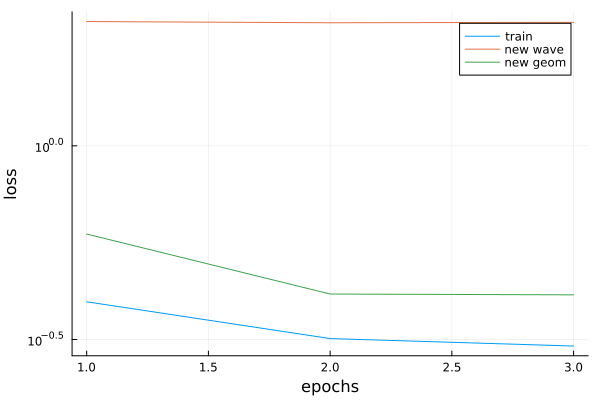

In [34]:
### plot loss as a function of epochs
# note in inference mode the loss will not decrease that much with multiple iterations
p3 = plot([list_loss_epoch,list_loss_epoch_test_wave,list_loss_epoch_test_geom], yaxis=:log, label = ["train" "new wave" "new geom"])
ylabel!("loss")
xlabel!("epochs")
display(p3)

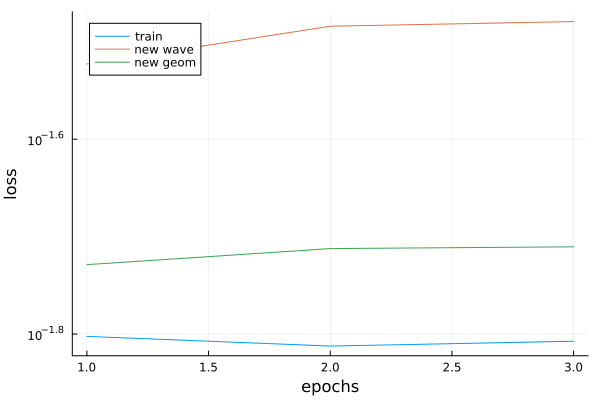

In [35]:
# plot loss as a function of epochs
# note in inference mode the loss will not decrease that much with multiple iterations, sometime can increase too
p4 = plot([list_S_loss_epoch,list_S_loss_epoch_test_wave,list_S_loss_epoch_test_geom], yaxis=:log, label = ["train" "new wave" "new geom"])
ylabel!("loss")
xlabel!("epochs")
display(p4)

## Read 1D results for comparison ##

In [36]:
filename1D = "/home/hunor/PhD/LANL/data/1Dsimulations/case10_1D_waveforms_results.h5"
file = h5open(filename1D,"r")
data1d_geom = read(file["data"])
close(file)

In [37]:
println("Size of 1D data matrix:", size(data1d_geom))
println("Shape: [timesteps, spatial locations, waveforms, variables]")
    
#variables: 1 - flow rate, 2 - pressure , 3 - area, 4 - WSS

Size of 1D data matrix:(300, 440, 10, 4)
Shape: [timesteps, spatial locations, waveforms, variables]


In [38]:
filename1D = "/home/hunor/PhD/LANL/data/1Dsimulations/case1to9_10_1D_waveforms_results.h5"
file = h5open(filename1D,"r")
data1d_wave = read(file["data"])
close(file)

In [39]:
data1d = cat(data1d_geom, data1d_wave,dims=3);

In [40]:
data1d_fix = data1d[200:end-1,Not(11:11:end),:,:];

In [41]:
flow_GT = permutedims(ytest_geom,(1,3,2));
flow_GT_wave = permutedims(ytest_wave,(1,3,2));
flow_GT_train = permutedims(ytrain2,(1,3,2));
#reshape prediction matrix
pred_train_mat = zero(flow_GT_train);
pred_test_wave_mat = zero(flow_GT_wave);
pred_test_geom_mat = zero(flow_GT);

for i in range(1,size(pred_train)[1])
    if i==size(pred_train)[1]
        pred_train_mat[:,batch_size*(i-1)+1:end,:] = pred_train[i]
    else
        pred_train_mat[:,batch_size*(i-1)+1:batch_size*i,:] = pred_train[i] 
    end
end


for i in range(1,size(pred_test_wave)[1])
    if i==size(pred_test_wave)[1]
        pred_test_wave_mat[:,batch_size*(i-1)+1:end,:] = pred_test_wave[i]
    else
        pred_test_wave_mat[:,batch_size*(i-1)+1:batch_size*i,:] = pred_test_wave[i] 
    end
end



for i in range(1,size(pred_test_geom)[1])
    if i==size(pred_test_geom)[1]
        pred_test_geom_mat[:,batch_size*(i-1)+1:end,:] = pred_test_geom[i]
    else
        pred_test_geom_mat[:,batch_size*(i-1)+1:batch_size*i,:] = pred_test_geom[i] 
    end
end

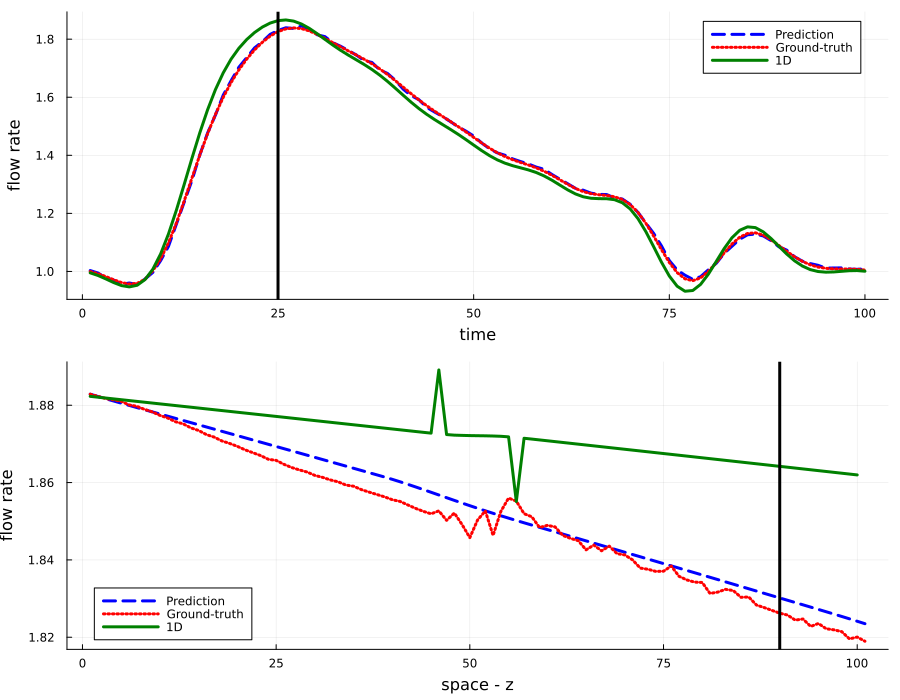

In [42]:
gr()
xpos = 90
t_time = 25
wf = 5
plot1 = plot(pred_test_geom_mat[1:end, wf, xpos], label="Prediction", linewidth=3, linestyle =:dash,color=:blue)
plot!(ytest_geom[1:end, xpos, wf], label="Ground-truth", linewidth=3,linestyle =:dot,color=:red)
plot!(data1d_fix[:,4*(xpos)+1,wf,1], label = "1D", linewidth=3,color=:green)
vline!([t_time],color = "black", linewidth = 3, label = "")
xlabel!("time")
ylabel!("flow rate")


plot2 = plot(pred_test_geom_mat[t_time, wf, :], label="Prediction", linewidth=3, linestyle =:dash,color=:blue)
plot!(ytest_geom[t_time, :, wf], label="Ground-truth", linewidth=3,linestyle =:dot, color=:red)
plot!(data1d_fix[t_time,1:4:end,wf,1], label = "1D", linewidth=3,color=:green)
vline!([xpos], color = "black", linewidth = 3, label = "")
plot!(size=(900,700))
xlabel!("space - z")
ylabel!("flow rate")

display(plot(plot1,plot2, layout = (2,1)))

In [43]:
pred_test_mat = cat(pred_test_geom_mat,pred_test_wave_mat[:,:,:],dims=2);
flow_GT_test = cat(flow_GT,flow_GT_wave[:,1:end,:],dims=2);

In [44]:
flow_err_node_test = norm(pred_test_mat[:, 1:end, :] - flow_GT_test[:, 1:end, :])/norm(flow_GT_test[:,1:end, :])
print("PCNDE flow rate prediction relative error - test: ", flow_err_node_test ,"\n")

flow_err_1d = norm(permutedims(data1d_fix[:,1:4:end,1:19,1],(1,3,2)) - flow_GT_test[:, 1:19, 1:end-1])/norm(flow_GT_test[:,1:19, 1:end-1])
print("1D FEM flow rate prediction relative error: ", flow_err_1d)

PCNDE flow rate prediction relative error - test: 0.0075234437152571715
1D FEM flow rate prediction relative error: 0.020371027466924107

In [45]:
flow_err_node_train = norm(pred_train_mat[:, 1:81, :] - flow_GT_train[:, 1:81, :])/norm(flow_GT_train[:,1:81, :])
print("PCNDE flow rate prediction relative error - training: ", flow_err_node_train ,"\n")

PCNDE flow rate prediction relative error - training: 0.003970394680170405


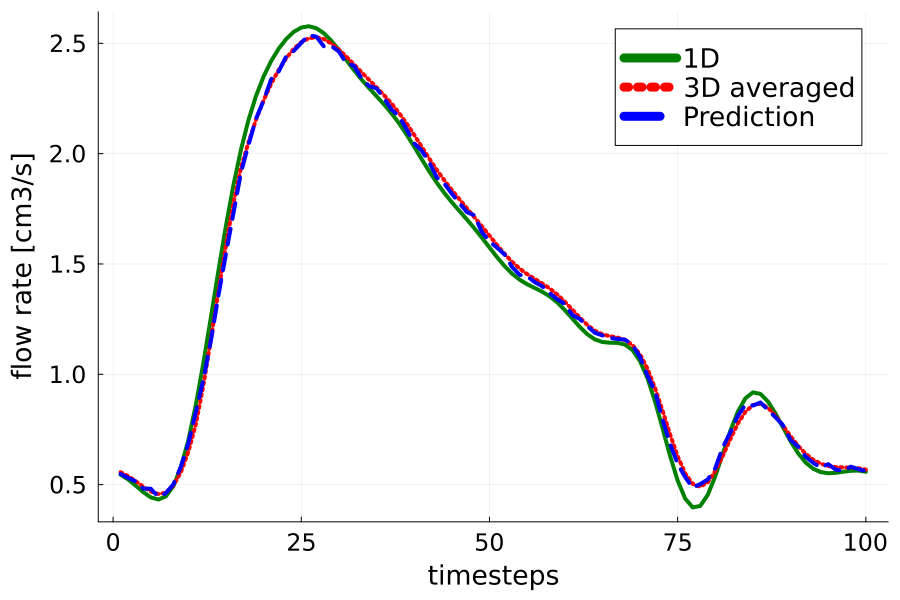

In [46]:
gr()
xpos =  90
wf = 10
plot(data1d_fix[:,4*xpos,wf,1], label = ["1D" "" "" "" "" "" "" "" "" ""], linewidth=4,linestyle =:solid, color=:green)
plot!(ytest_geom[:, xpos, wf], label=["3D averaged" "" "" "" "" "" "" "" "" ""], linewidth=4,linestyle =:dot, color=:red,yguidefontsize=18,legendfontsize=18,xguidefontsize=18)
plot!(pred_test_geom_mat[:, wf, xpos], label=["Prediction" "" "" "" "" "" "" "" "" ""], linewidth=4, linestyle =:dash, color=:blue)

xlabel!("timesteps", xtickfontsize=16,ytickfontsize=16,left_margin=5Plots.mm,bottom_margin=5Plots.mm)
ylabel!("flow rate [cm3/s]")
plot!(size=(900,600))

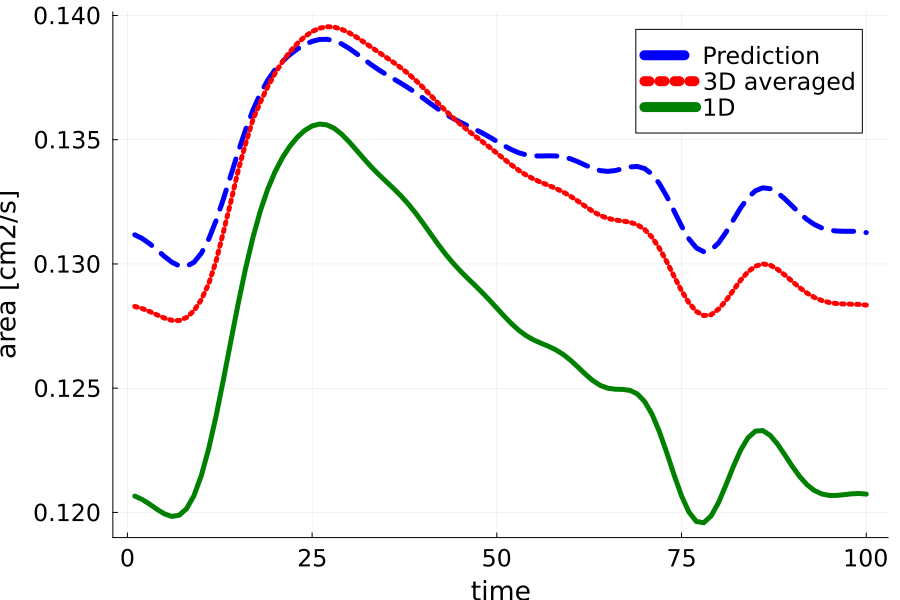

In [47]:
xpos = 90
plot(Atest_geom[:, xpos, 10], label="Prediction", linewidth=5, linestyle =:dash, color=:blue)
plot!(Atest_geom_org[:, xpos, 10], label="3D averaged", linewidth=5,linestyle =:dot, color=:red)
plot!(data1d_fix[:,4*xpos,10,3], label = "1D", linewidth=5,linestyle =:solid, color=:green)
xlabel!("time", xtickfontsize=16,ytickfontsize=16,xaxis=:true,yaxis=:true)
ylabel!("area [cm2/s]",yguidefontsize=18,legendfontsize=16,xguidefontsize=18)
plot!(size=(900,600))

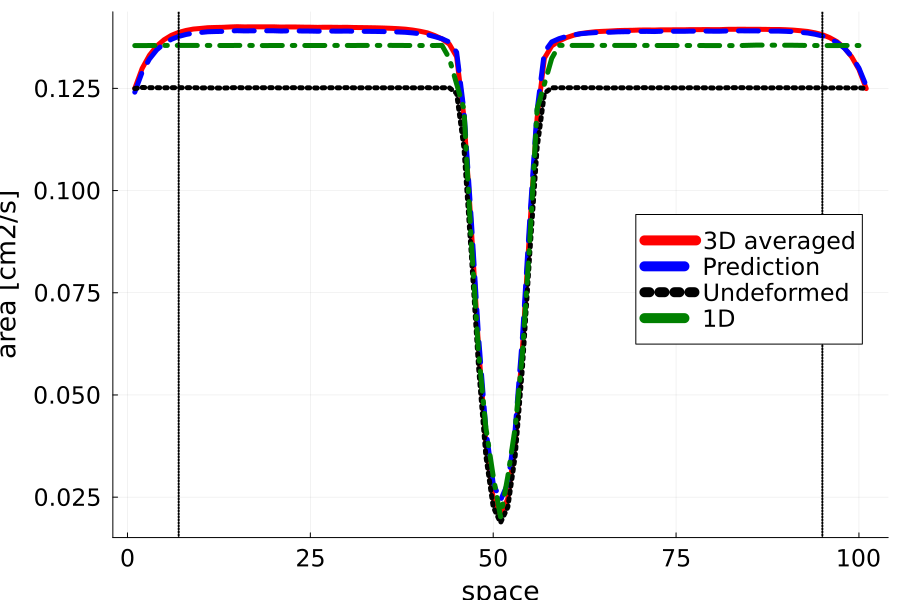

In [48]:
gr()
time = 25
plot(Atest_geom_org[time, :, 10], label="3D averaged", linewidth=5,linestyle =:solid, color=:red)
plot!(Atest_geom[time, :, 10], label="Prediction", linewidth=5, linestyle =:dash, color=:blue)
plot!(Atest_geom_undef[time, :, 10], label="Undeformed", linewidth=5,linestyle =:dot, color=:black)
plot!(data1d_fix[time,1:4:end,10,3], label = "1D", linewidth=5,linestyle =:dashdot, color=:green)
xlabel!("space", xtickfontsize=16,ytickfontsize=16,xaxis=:true,yaxis=:true)
ylabel!("area [cm2/s]",yguidefontsize=18,legendfontsize=16,xguidefontsize=18, legend=:right)
# Add vertical lines at x=5 and x=end-5
x_length = size(Atest_geom_org, 2)  # Assuming the second dimension is the x-axis length
vline!([7, x_length-6], linewidth=2, linestyle=:dot, color=:black, label="")

plot!(size=(900,600))

In [49]:
#reshape for further error calculation
big_Vec = reshape(permutedims(pred_test_geom_mat[:,1:end,1:end-1],(1,3,2)),(1,:))
big_Vec_GT = reshape(permutedims(flow_GT_test,(1,3,2))[:,1:end-1,1:1end],(1,:))
big_Vec_1D = reshape(data1d_fix[:,1:4:end,:,1],(1,:))
rand_indices_all = shuffle(collect(1:size(big_Vec)[2]));

In [50]:
area_test = cat(Atest_geom,Atest_wave[:,:,1:end],dims=3);
area_test_org = cat(Atest_geom_org,Atest_wave_org[:,:,1:end],dims=3);

area_err_node_test = norm(area_test[:,6:end-5, :] - area_test_org[:,6:end-5, :]) / norm(area_test_org[:,6:end-5, :])
area_err_1d = norm(data1d_fix[:,21:4:end-16,:,3] - area_test_org[:,6:end-5, 1:end]) / norm(area_test_org[:,6:end-5, 1:end])
print("Neural ODE area prediction relative error:test", area_err_node_test ,"\n")
print("1D FEM area prediction relative error: ", area_err_1d)

Neural ODE area prediction relative error:test0.011368323428947788
1D FEM area prediction relative error: 0.049829130248411804

In [51]:
area_err_node_train = norm(Atrain[:,6:end-5, 1:81] - Atrain_org[:,6:end-5, 1:81]) / norm(Atrain_org[:,6:end-5, 1:81])
print("Neural ODE area prediction relative error - training: ", area_err_node_train ,"\n")

Neural ODE area prediction relative error - training: 0.007682784679077795


In [52]:
#reshape for further error calculation
big_Vec_S = reshape(area_test[:,1:end-1,1:end],(1,:))
big_Vec_GT_S = reshape(area_test_org[:,1:end-1,1:end],(1,:))
big_Vec_1D_S = reshape(data1d_fix[:,1:4:end,:,3],(1,:));

rand_indices = rand_indices_all; # use all points
#calculate relative point-wise errors for box-plot
rel_err_1D = abs.(big_Vec_1D[rand_indices].-big_Vec_GT[rand_indices])./(big_Vec_GT[rand_indices]);
rel_err_NDE = abs.(big_Vec[rand_indices].-big_Vec_GT[rand_indices])./(big_Vec_GT[rand_indices]);

rel_err_1D_S = abs.(big_Vec_1D_S[rand_indices].-big_Vec_GT_S[rand_indices])./(big_Vec_GT_S[rand_indices]);
rel_err_NDE_S = abs.(big_Vec_S[rand_indices].-big_Vec_GT_S[rand_indices])./(big_Vec_GT_S[rand_indices]);

In [53]:
err_train_S  =zeros(size(Atrain)[3])
max_err_train_S = 0.0
max_ID_train = 0.0
for i in range(1,size(Atrain)[3])
   err_train_S[i] = norm(Atrain[:,:,i] - Atrain_org[:,:,i]) ./ norm(Atrain_org[:,:,i])
   if err_train_S[i] > max_err_train_S
        max_err_train_S = err_train_S[i]
        max_ID_train = i
   end
end
println("Max S error training ID:",max_ID_train)
println("Max S error training:",max_err_train_S)


err_wave_S  =zeros(size(Atest_wave)[3])
max_err_wave_S = 0.0
max_ID_wave = 0.0
for i in range(1,size(Atest_wave)[3])
   err_wave_S[i] = norm(Atest_wave[:,:,i] - Atest_wave_org[:,:,i]) ./ norm(Atest_wave_org[:,:,i])
   if err_wave_S[i] > max_err_wave_S
        max_err_wave_S = err_wave_S[i]
        max_ID_wave = i
   end
end
println("Max S error ID - test, new waveform:",max_ID_wave)
println("Max S error - test, new waveform:",max_err_wave_S)



err_geom_S  =zeros(size(Atest_geom)[3])
max_err_geom_S = 0.0
max_ID_geom = 0.0
for i in range(1,size(Atest_geom)[3])
   err_geom_S[i] = norm(Atest_geom[:,:,i] - Atest_geom_org[:,:,i]) ./ norm(Atest_geom_org[:,:,i])
   if err_geom_S[i] > max_err_geom_S
        max_err_geom_S = err_geom_S[i]
        max_ID_geom = i
   end
end
println("Max S error ID - test, new stenosis:",max_ID_geom)
println("Max S error - test, new stenosis:",max_err_geom_S)

Max S error training ID:1
Max S error training:0.012109423552232292
Max S error ID - test, new waveform:9
Max S error - test, new waveform:0.013379999174993815
Max S error ID - test, new stenosis:10
Max S error - test, new stenosis:0.014207761699747178


In [54]:
err_train_Q  = zeros(size(pred_train_mat)[2])
max_err_train_Q = 0.0
max_ID_train_Q = 0.0
for i in range(1,size(pred_train_mat)[2])
   err_train_Q[i] = norm(pred_train_mat[:,i,:] - flow_GT_train[:,i,:]) ./ norm(flow_GT_train[:,i,:])
   if err_train_Q[i] > max_err_train_Q
        max_err_train_Q = err_train_Q[i]
        max_ID_train_Q = i
   end
end
println("Max Q  error training ID:",max_ID_train_Q)
println("Max Q error training:",max_err_train_Q)


err_wave_Q  =zeros(size(pred_test_wave_mat)[2])
max_err_wave_Q = 0.0
max_ID_wave_Q = 0.0
for i in range(1,size(pred_test_wave_mat)[2])
   err_wave_Q[i] = norm(pred_test_wave_mat[:,i,:] - flow_GT_wave[:,i,:]) ./ norm(flow_GT_wave[:,i,:])
   if err_wave_Q[i] > max_err_wave_Q
        max_err_wave_Q = err_wave_Q[i]
        max_ID_wave_Q = i
   end
end
println("Max Q error ID - test, new waveform:",max_ID_wave_Q)
println("Max Q error - test, new waveform:",max_err_wave_Q)



err_geom_Q  =zeros(size(pred_test_geom_mat)[2])
max_err_geom_Q = 0.0
max_ID_geom_Q = 0.0
for i in range(1,size(pred_test_geom_mat)[2])
   err_geom_Q[i] = norm(pred_test_geom_mat[:,i,:] - flow_GT[:,i,:]) ./ norm(flow_GT[:,i,:])
   if err_geom_Q[i] > max_err_geom_Q
        max_err_geom_Q = err_geom_Q[i]
        max_ID_geom_Q = i
   end
end
println("Max Q error ID - test, new stenosis:",max_ID_geom_Q)
println("Max Q error - test, new stenosis:",max_err_geom_Q)

Max Q  error training ID:27
Max Q error training:0.0059024838750095
Max Q error ID - test, new waveform:5
Max Q error - test, new waveform:0.009966480589719644
Max Q error ID - test, new stenosis:10
Max Q error - test, new stenosis:0.009208771664968009


In [55]:
err_geom_Q_1D  =zeros(size(data1d_fix[:,:,:,3])[3])
max_err_geom_Q_1D = 0.0
max_ID_geom_Q_1D = 0.0
for i in range(1,size(data1d_fix[:,:,:,3])[3])
    err_geom_Q_1D[i] = norm(data1d_fix[:,1:4:end,i,1] - flow_GT_test[:,i,1:end-1]) ./ norm(flow_GT_test[:,i,1:end-1])
   if err_geom_Q_1D[i] > max_err_geom_Q_1D
        max_err_geom_Q_1D = err_geom_Q_1D[i]
        max_ID_geom_Q_1D = i
   end
end


err_geom_S_1D  =zeros(size(data1d_fix[:,:,:,3])[3])
max_err_geom_S_1D = 0.0
max_ID_geom_1D = 0.0
for i in range(1,size(data1d_fix[:,:,:,3])[3])
    err_geom_S_1D[i] = norm(data1d_fix[:,1:4:end,i,3] - area_test_org[:,1:end-1,i]) ./ norm(area_test_org[:,1:end-1,i])
   if err_geom_S_1D[i] > max_err_geom_S_1D
        max_err_geom_S_1D = err_geom_S_1D[i]
        max_ID_geom_1D = i
   end
end

### Note: for some reasons heatmaps don't render well on GitHub so all of them are commented out
### These heatmaps produce Fig. 6 and Fig. 4d.

In [115]:
# wf = 10
# h2 = heatmap(pred_test_geom_mat[:,wf,:]',color=:viridis)
# ylabel!("space")
# title!("Q - predicted")
# h1 = heatmap(ytest_geom[:,:,wf]',color=:viridis)
# ylabel!("space")
# title!("Q - ground truth")
# h3 = heatmap(abs.(pred_test_geom_mat[:,wf,:]' - ytest_geom[:,:,wf]'), color=:viridis)
# ylabel!("space")
# xlabel!("time")
# title!("Absolute error")
# plot!(size=(700,900))
# display(plot(h1,h2,h3,layout=(3,1)))

In [116]:
# wf = 10
# h2 = heatmap(∂x1 * permutedims(pred_test_geom_mat,(1,3,2))[:,:,wf]',color=:viridis)
# ylabel!("space")
# xlabel!("time")
# title!("Q - predicted")
# h1 = heatmap(∂x1 * ytest_geom[:,:,wf]',color=:viridis)
# ylabel!("space")
# xlabel!("time")
# title!("Q - ground truth")
# display(plot(h1,h2,layout=(2,1)))

In [117]:
# wf = 10
# h2 = heatmap(area_test[:,:,wf]',color=:viridis)
# ylabel!("space")
# title!("area predicted")
# h1 = heatmap(area_test_org[:,:,wf]',color=:viridis)
# ylabel!("space")
# title!("S - ground truth")
# h3 = heatmap(abs.(area_test[:,:,wf]' - area_test_org[:,:,wf]'), color=:viridis)
# ylabel!("space")
# xlabel!("time")
# title!("Absolute error")
# h4 = heatmap(abs.(area_test[:,:,wf]' - area_test_org[:,:,wf]')./area_test[1,:,wf], color=:viridis)
# ylabel!("space")
# xlabel!("time")
# title!("Normalized error")
# plot!(size=(700,900))
# display(plot(h1,h2,h4,layout=(3,1)))

In [59]:
main_block_S = hcat(reshape(err_train_S[1:end],(9,9))',err_wave_S[1:end])
last_row_S = reshape(err_geom_S[1:end],(1,10))
error_matrix_S = vcat(main_block_S,last_row_S)


main_block_Q = hcat(reshape(err_train_Q[1:end],(9,9))',err_wave_Q[1:end])
last_row_Q = reshape(err_geom_Q[1:end],(1,10))
error_matrix_Q = vcat(main_block_Q,last_row_Q);

In [118]:
# gr()
# heatmap(error_matrix_S, yflip=true)
# plot!(Shape([0.5, 0.5, 9.5, 9.5], [0.5, 9.5, 9.5, 0.5]), label="", fillcolor=:transparent, linecolor=:black, linewidth=2)
# xlabel!("waveforms")
# ylabel!("geometries")
# title!("Area error")
# display(current())  # Force display of the plot

In [119]:
# minS = minimum(error_matrix_S)
# maxS = maximum(err_geom_S_1D);

# heatmap(error_matrix_Q, yflip=true)
# plot!(Shape([0.5, 0.5, 9.5, 9.5], [0.5, 9.5, 9.5,0.5]), label = "", fillcolor=:transparent, linecolor=:black, linewidth = 2)
# xlabel!("waveforms")
# ylabel!("geometries")
# title!("Flow rate error")

In [62]:
minQ = minimum(error_matrix_Q)
maxQ = maximum(err_geom_Q_1D);

# Pressure #

In [63]:
# create arrays with area data
pref = 133322.0; # [dyn/cm2] reference pressure
pID = 2 # pressure*area
# pID+1 = 3 is undeformed area
skip_sides = 0
ptrain = data_mat[:,1+skip_sides:end-skip_sides,train_indices,pID]./data_mat[:,1+skip_sides:end-skip_sides,train_indices,pID+1];
ptrain = ptrain./pref
ptest_wave =  data_mat[:,1+skip_sides:end-skip_sides,test_indices_wave,pID]./data_mat[:,1+skip_sides:end-skip_sides,test_indices_wave,pID+1];
ptest_wave = ptest_wave./pref
ptest_geom = data_mat[:,1+skip_sides:end-skip_sides,test_indices_geom,pID]./data_mat[:,1+skip_sides:end-skip_sides,test_indices_geom,pID+1];
ptest_geom = ptest_geom./pref;

N = size(ptrain,2);

In [64]:
# Define the network architecture with initialization
hidden_dim = 2
depth_p = 2

ann = make_nn(4*N,N,hidden_dim,depth_p,gelu,identity)
# flatten parameters in NN for learning.                
p, re = Flux.destructure(ann);
ps = deepcopy(p)
p_size = size(p,1);
println("Number of parameters in neural network for pressure equation: $p_size"); 

Number of parameters in neural network for pressure equation: 1119


In [65]:
ann

Chain(
  Dense(404 => 2, gelu),                # 810 parameters
  Dense(2 => 2, gelu),                  # 6 parameters
  Dense(2 => 101),                      # 303 parameters
)                   # Total: 6 arrays, 1_119 parameters, 4.746 KiB.

In [66]:
# parameters for pressure equation                
p_pres = ones(8 .* size(ptrain[:,1,1]))
ps_pres = deepcopy(p_pres)
pres_size = size(p_pres,1);
println("Number of parameters in pp vector for pressure equation: $pres_size"); 

Number of parameters in pp vector for pressure equation: 800


In [67]:
Nspace = size(ptrain,2)   # number of points in space
Ntime = size(ptrain,1)
x = 0.0 : dz : L        # discretized spatial dimension 

# finite-difference schemes for spatial derivatives

#first order derivatives for space
∂x1_center = f1_secondOrder_central(Nspace,dz);
∂x1_forward = f1_secondOrder_forward(Nspace,dz);
∂x1_backward = f1_secondOrder_backward(Nspace,dz);

# use central difference for the majority
∂x1 = ∂x1_center
# use forward and backward difference near the boundaries
∂x1[1,:]=∂x1_forward[1,:]
∂x1[end,:] = ∂x1_backward[end,:]

∂x1_FW = ∂x1_forward
∂x1_FW[end-2:end,:] = ∂x1_backward[end-2:end,:]

#second order derivatives
∂x2_center = f2_secondOrder_central(Nspace,dz);
∂x2_forward = f2_secondOrder_forward(Nspace,dz);
∂x2_backward = f2_secondOrder_backward(Nspace,dz);

# use central difference for the majority
∂x2 = ∂x2_center;
# use forward and backward difference near the boundaries
∂x2[1,:]=∂x2_forward[1,:];
∂x2[end,:] = ∂x2_backward[end,:];


#first order derivatives for time

∂t1_center = f1_secondOrder_central(Ntime,dt);
∂t1_forward = f1_secondOrder_forward(Ntime,dt);
∂t1_backward = f1_secondOrder_backward(Ntime,dt);

# use central difference for the majority
∂t1 = ∂t1_center
# use forward and backward difference near the boundaries
∂t1[1,:]=∂t1_forward[1,:]
∂t1[end,:] = ∂t1_backward[end,:];

function ddx(ptrain)
    dpdx = NNlib.batched_mul(∂x1, permutedims(ptrain[:,:,:],(1,2,3)))
    dpdx = permutedims(dpdx,(1,2,3))
    return dpdx
end;

function ddt(ptrain)
    dpdt = NNlib.batched_mul(∂t1,permutedims(ptrain,(2,1,3)))
    return permutedims(dpdt,(2,1,3)) 
end;

In [68]:
function ddx(ptrain)
    dpdx = NNlib.batched_mul(∂x1_FW, permutedims(ptrain[:,:,:],(1,2,3)))
    dpdx = permutedims(dpdx,(1,2,3))
    return dpdx
end;

function ddt(ptrain)
    dpdt = NNlib.batched_mul(∂t1,ptrain)
    return dpdt 
end;

In [69]:
function loss_press_train(ps, Atrain, ptrain, Atrain_undef, ytrain, pref, Ehr,λ)
    batch = size(Atrain)[3]
    

    Φ = re(ps)

    S_S0 = Atrain ./ Atrain_undef
    v = ytrain ./ Atrain
    Atrain_base = maximum(mean(Atrain,dims=(1)),dims=2);
    A_stenosis = minimum(Atrain,dims=(1));

    Kv = 32 .* Ls .* Atrain_base.^2 ./ (A_stenosis.^2 .* 2 .*r0);
    Re = ρ ./ν * (ytrain ./ Atrain_base) .* (2 .* r0);
    Δp = Kt .* ρ .* ytrain.^2 ./ (2 .* Atrain_base.^2) .* (Atrain_base./A_stenosis.-ones(size(Atrain_undef))).^2 + ρ .* ytrain.^2 ./ Atrain_base .^2 .* Kv ./ Re;
    Δp = Δp ./pref


    p = ones(size(Atrain[:,:,:])) + Ehr.*Φ(vcat(Atrain,Atrain.-Atrain_undef,Δp,ytrain))./pref
    
    loss_rec = sum(abs2,p - ptrain)
    loss_dpdz = sum(abs2,ddx(ptrain) - ddx(p))

    loss = loss_rec  .+ λ*loss_dpdz # λ is zero so 2nd term doesn't matter
    return loss, p
end

loss_press_train (generic function with 1 method)

In [70]:
# E = 15000000 [CGS] - vessel wall Young modulus
# h = 0.05 cm - vessel wall thickness
# r = 0.2 cm vessel radius
# parabolic flow profile constant
# https://simvascular.github.io/docs1DSimulation.html#solver
δ = 1/3;
# viscosity in CGS units
ν = 0.04;
# velocity profile constant
Nprof = -8*π*ν;
E = 15000000;
h = 0.05;
r0 = 0.2;
Ehr = E*h/r0;
β = E*h*sqrt.(π);
ρ = 1.06; # fluid density in [g/cm3]
Ls = 0.45; # stenosis length in [cm]
S_stenosis = minimum(Atrain,dims=(1,2)); #stenosis minimal area
Kt = 1.52;

In [71]:
Atrain_base = maximum(mean(Atrain_org,dims=(1)),dims=2);
A_stenosis = minimum(Atrain_org,dims=(1,2));
Kv = 32 .* Ls .* Atrain_base.^2 ./ (A_stenosis.^2 .* 2 .*r0);
Re = ρ ./ν * (ytrain2 ./ Atrain_base) .* (2 .* r0);
Δp = Kt .* ρ .* ytrain2.^2 ./ (2 .* Atrain_base.^2) .* (Atrain_base./A_stenosis.-ones(size(Atrain_undef))).^2 + ρ .* ytrain2.^2 ./ Atrain_base .^2 .* Kv ./ Re;
Δp = Δp ./pref;

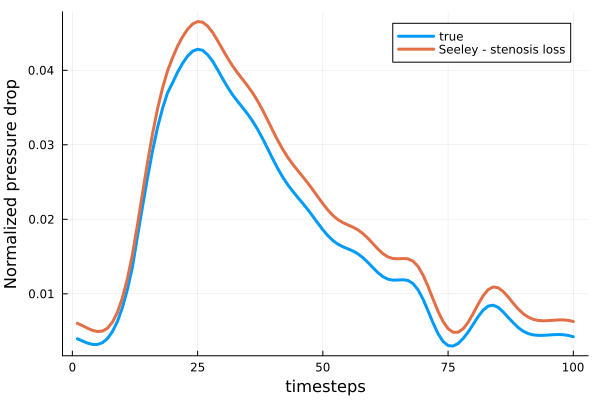

In [72]:
wf=81
plot(ptrain[:,40,wf] .- ptrain[:,60,wf],label = "true", linewidth = 3)
plot!(Δp[:,50,wf], label = "Seeley - stenosis loss", linewidth = 3)
xlabel!("timesteps")
ylabel!("Normalized pressure drop")

In [73]:
function loss_press(ps, Atrain, ptrain, Atrain_undef, ytrain, pref, Ehr,λ)
    batch = size(Atrain)[3]
    

    Φ = re(ps)
    S_S0 = Atrain ./ Atrain_undef
    v = ytrain ./ Atrain
    Atrain_base = maximum(mean(Atrain,dims=(1)),dims=2);
    A_stenosis = minimum(Atrain,dims=(1));
    Kv = 32 .* Ls .* Atrain_base.^2 ./ (A_stenosis.^2 .* 2 .*r0);
    Re = ρ ./ν * (ytrain ./ Atrain_base) .* (2 .* r0);
    Δp = Kt .* ρ .* ytrain.^2 ./ (2 .* Atrain_base.^2) .* (Atrain_base./A_stenosis.-ones(size(Atrain_undef))).^2 + ρ .* ytrain.^2 ./ Atrain_base .^2 .* Kv ./ Re;
    Δp = Δp ./pref
    

    p = ones(size(Atrain[:,:,:])) + Ehr.*Φ(vcat(Atrain,Atrain.-Atrain_undef,Δp,ytrain))./pref
    
    loss_rec = sum(abs2,p - ptrain)
    loss_dpdz = sum(abs2,ddx(ptrain) - ddx(p))

    loss = loss_rec  .+ λ*loss_dpdz 
    return loss, loss_dpdz, loss_rec, p
end

loss_press (generic function with 1 method)

In [74]:
callback = function (θ,l, pred)
    global iters += 1 
    println("Iteration: $iters || Loss: $l")
    flush(stdout) 
    false
end 
function train_BFGS(uinit, optf)
    path_checkpoint_new = "/home/hunor/PhD/LANL/revision/dQdz_FourierSeries_Final/learn_p/restartCkpt_BFGS_new.jld2"
    optprob = Optimization.OptimizationProblem(optf,uinit);    
    # Training 
    res = Optimization.solve(optprob, 
                            Optim.BFGS(initial_stepnorm=0.01),
                            #Optim.BFGS(linesearch=LineSearches.BackTracking(),initial_stepnorm=0.01),
                            callback = callback,       
                            allow_f_increases = false,
                            maxiters = train_maxiters*5);
    println("saving BFGS checkpoint...")
    jldsave(path_checkpoint_new, ckpt=res)
    return res
end

function train_ADAM(uinit, optf, learning_rate)
    path_checkpoint_new = "./learn_p/restartCkpt_ADAM_new.jld2"
    optprob = Optimization.OptimizationProblem(optf,uinit);    
    # Training 
    res = Optimization.solve(optprob, 
                            OptimizationOptimisers.Adam(learning_rate), 
                            callback = callback, 
                            maxiters = train_maxiters)
    println("saving ADAM checkpoint...")
    jldsave(path_checkpoint_new, ckpt=res)
    return res
end

train_ADAM (generic function with 1 method)

In [75]:
n_epochs = 5
#set batch size
batch_size = 81 # 81 is full batch
println("Batch size:", batch_size)
println("############################################")
#training batches
batch_iterations = Int(ceil(size(ptrain,3)/batch_size))
#testing batches
test_wave_batch_iterations = Int(ceil(size(ptest_wave,3)/batch_size));
test_geom_batch_iterations = Int(ceil(size(ptest_geom,3)/batch_size));

Batch size:81
############################################


In [76]:
transfer_learning = true
if transfer_learning == false
    uinit_p = deepcopy(p_pres);
    uinit_NN = deepcopy(ps);
    println("New training initialized!")
else
    p = load("/home/hunor/PhD/LANL/summer2024/dQdz_FourierSeries/ptrained_BFGS_p.jld2")
    uinit_NN = p["p"]
    println("Parameters loaded from file!")
end

Parameters loaded from file!


In [77]:
list_loss_epoch = []
list_loss_test_wave = []
list_loss_epoch_test_wave = []
list_loss_test_geom = []
list_loss_epoch_test_geom = []

learning_rate = 1e-1;
λ = 0.0 # no dpdz loss
for j in 1:n_epochs
    println("Start training epoch ",j)
    loss_tot = 0.0
    loss_tot_test_wave = 0.0
    loss_tot_test_geom = 0.0
    
    loss_tot_dpdz = 0.0
    loss_tot_test_wave_dpdz = 0.0
    loss_tot_test_geom_dpdz = 0.0
    
    loss_tot_rec = 0.0
    loss_tot_test_wave_rec = 0.0
    loss_tot_test_geom_rec = 0.0
        # loop over different waveforms
        for i in 1:batch_iterations

            println("waveform batch: ",i, "/",batch_iterations)
            flush(stdout)
            #reorder ytrain, atrain to [time, batch_size, spatial location]

            if i!=batch_iterations
                Ptrain = permutedims(ptrain[:,:,batch_size*(i-1)+1:batch_size*i],(2,1,3))
                ytrain = permutedims(pred_train_mat[:,batch_size*(i-1)+1:batch_size*i,1+skip_sides:end-skip_sides],(3,1,2))
                atrain = permutedims(Atrain[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:batch_size*i],(2,1,3))
                atrain_undef = permutedims(Atrain_undef[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:batch_size*i],(2,1,3))
            else
                Ptrain = permutedims(ptrain[:,:,batch_size*(i-1)+1:end],(2,1,3))
                ytrain = permutedims(pred_train_mat[:,batch_size*(i-1)+1:end,1+skip_sides:end-skip_sides],(3,1,2))
                atrain = permutedims(Atrain[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:end],(2,1,3))
                atrain_undef = permutedims(Atrain_undef[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:end],(2,1,3))
            
            end
            # these are not being used, only BFGS is being used and no dpdz loss
            if j == 100 && i==1
                global learning_rate = learning_rate * 0.1
                println("Changing ADAM learning rate to:",learning_rate)
                global λ = 1e3;
                println("Changing dp/dz loss lambda to:",λ)
            elseif j ==  301 && i==1
                global λ = 1e4;
                println("Changing dp/dz loss lambda to:",λ)
            end
        
        
            global optf_NN = Optimization.OptimizationFunction((uinit_NN,x)->loss_press_train(uinit_NN,atrain,Ptrain,atrain_undef,ytrain,pref,Ehr,λ),adtype);
            
            if j < 1 #it always uses BFGS directly
                global iters = 0 ;
                resnew = train_ADAM(uinit_NN, optf_NN, learning_rate)
                global uinit_NN = resnew.u
                jldsave("ptrained_ADAM_p.jld2",p=resnew.u)
                println("ADAM: Sum NN pressure params:",sum(uinit_NN))
            else
                global iters = 0 ;
                resnew = train_BFGS(uinit_NN, optf_NN);
                global uinit_NN = resnew.u
                jldsave("ptrained_BFGS_p.jld2",p=resnew.u)
                println("BFGS: Sum NN pressure params:",sum(uinit_NN))
            end
        
        
            loss_pres, loss_dpdz, loss_rec ,p_pred = loss_press(uinit_NN, atrain, Ptrain, atrain_undef, ytrain, pref, Ehr,λ);
            loss_tot = loss_tot + loss_pres
            loss_tot_dpdz += loss_dpdz
            loss_tot_rec += loss_rec

        end
    
    
        # loop over different waveforms
        for i in 1:test_wave_batch_iterations

            println("waveform batch: ",i, "/",test_wave_batch_iterations)
            flush(stdout)


            if i!=test_wave_batch_iterations
                Ptest = permutedims(ptest_wave[:,:,batch_size*(i-1)+1:batch_size*i],(2,1,3))
                ytest = permutedims(pred_test_wave_mat[:,batch_size*(i-1)+1:batch_size*i,1+skip_sides:end-skip_sides],(3,1,2))
                atest = permutedims(Atest_wave[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:batch_size*i],(2,1,3))
                atest_undef = permutedims(Atest_wave_undef[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:batch_size*i],(2,1,3))
            
                
            else
                Ptest = permutedims(ptest_wave[:,:,batch_size*(i-1)+1:end],(2,1,3))
                ytest = permutedims(pred_test_wave_mat[:,batch_size*(i-1)+1:end,1+skip_sides:end-skip_sides],(3,1,2))
                atest = permutedims(Atest_wave[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:end],(2,1,3))
                atest_undef = permutedims(Atest_wave_undef[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:end],(2,1,3))
            
            end

        
            
            loss_pres, loss_dpdz, loss_rec ,p_pred = loss_press(uinit_NN, atest, Ptest, atest_undef, ytest, pref, Ehr,λ);
            loss_tot_test_wave = loss_tot_test_wave + loss_pres
            loss_tot_test_wave_dpdz += loss_dpdz
            loss_tot_test_wave_rec += loss_rec
            push!(pred_test_wave, p_pred)
        
        end
    
    
    
                    # loop over different waveforms
        for i in 1:test_geom_batch_iterations

            println("waveform batch: ",i, "/",test_geom_batch_iterations)
            flush(stdout)

            if i!=test_geom_batch_iterations
                Ptest = permutedims(ptest_geom[:,:,batch_size*(i-1)+1:batch_size*i],(2,1,3))
                ytest = permutedims(pred_test_geom_mat[:,batch_size*(i-1)+1:batch_size*i,1+skip_sides:end-skip_sides],(3,1,2))
                atest = permutedims(Atest_geom[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:batch_size*i],(2,1,3))
                atest_undef = permutedims(Atest_geom_undef[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:batch_size*i],(2,1,3))
            
            
            else
                Ptest = permutedims(ptest_geom[:,:,batch_size*(i-1)+1:end],(2,1,3))
                ytest = permutedims(pred_test_geom_mat[:,batch_size*(i-1)+1:end,1+skip_sides:end-skip_sides],(3,1,2))
                atest = permutedims(Atest_geom[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:end],(2,1,3))
                atest_undef = permutedims(Atest_geom_undef[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:end],(2,1,3))
            
            
            end

            
            
            loss_pres, loss_dpdz, loss_rec ,p_pred = loss_press(uinit_NN, atest, Ptest, atest_undef, ytest, pref, Ehr, λ);
            loss_tot_test_geom = loss_tot_test_geom + loss_pres
            loss_tot_test_geom_dpdz += loss_dpdz
            loss_tot_test_geom_rec += loss_rec
            push!(pred_test_geom, p_pred)
        
        end
    
    # save and print losses
    push!(list_loss_epoch, loss_tot/(size(ptrain,3)))
    push!(list_loss_epoch_test_wave, loss_tot_test_wave/(size(ptest_wave,3)))
    push!(list_loss_epoch_test_geom, loss_tot_test_geom/(size(ptest_geom,3)))
    println("Epoch ", j, " mean train loss:", loss_tot/(size(ptrain,3)))
    println("Epoch ", j, " mean train rec loss:", loss_tot_rec/(size(ptrain,3)))
    println("Epoch ", j, " mean train dpdz loss:", loss_tot_dpdz/(size(ptrain,3)))
    println("Epoch ", j, " mean test loss - new waveform:", loss_tot_test_wave/(size(ptest_wave,3)))
    println("Epoch ", j, " mean test loss  rec - new waveform:", loss_tot_test_wave_rec/(size(ptest_wave,3)))
    println("Epoch ", j, " mean test loss dpdz - new waveform:", loss_tot_test_wave_dpdz/(size(ptest_wave,3)))

    println("Epoch ", j, " mean test loss - new geom:", loss_tot_test_geom/(size(ptest_geom,3)))
    println("Epoch ", j, " mean test loss rec new geom:", loss_tot_test_geom_rec/(size(ptest_geom,3)))
    println("Epoch ", j, " mean test loss dpdz new geom:", loss_tot_test_geom_dpdz/(size(ptest_geom,3)))
    
end

Start training epoch 1
waveform batch: 1/1
Iteration: 1 || Loss: 53.98059592851117
Iteration: 2 || Loss: 53.977489978129015
Iteration: 3 || Loss: 53.6165508378562
Iteration: 4 || Loss: 53.376740910319825
Iteration: 5 || Loss: 53.30876479398971
Iteration: 6 || Loss: 53.29599926320883
Iteration: 7 || Loss: 49.40670981549028
Iteration: 8 || Loss: 49.30698318598025
Iteration: 9 || Loss: 45.27523171000624
Iteration: 10 || Loss: 44.94683303771506
Iteration: 11 || Loss: 44.72231056941305
Iteration: 12 || Loss: 43.698512484876304
Iteration: 13 || Loss: 43.674388210709736
Iteration: 14 || Loss: 42.83271890904596
Iteration: 15 || Loss: 42.82913713864366
Iteration: 16 || Loss: 42.7358074550073
Iteration: 17 || Loss: 42.73551405228464
Iteration: 18 || Loss: 42.63441578126791
Iteration: 19 || Loss: 42.62973760601895
Iteration: 20 || Loss: 42.38140101871423
Iteration: 21 || Loss: 42.37802598453732
Iteration: 22 || Loss: 42.26483441166906
Iteration: 23 || Loss: 42.26268127266438
Iteration: 24 || Loss

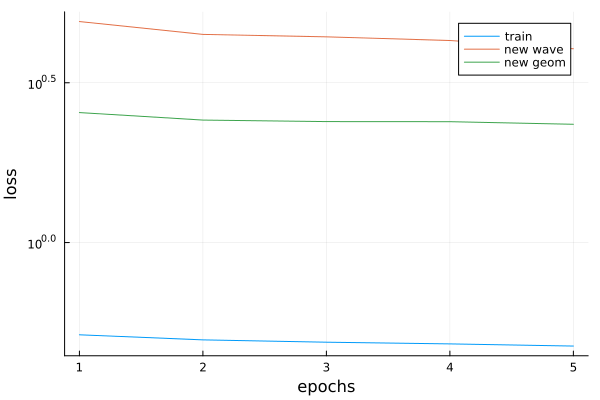

In [78]:
### plot loss as a function of epochs
p3 = plot([list_loss_epoch,list_loss_epoch_test_wave,list_loss_epoch_test_geom], yaxis=:log, label = ["train" "new wave" "new geom"])
ylabel!("loss")
xlabel!("epochs")
display(p3)

In [79]:
@time begin
list_loss_epoch = []
list_loss_test_wave = []
list_loss_epoch_test_wave = []
list_loss_test_geom = []
list_loss_epoch_test_geom = []

learning_rate = 1e-1;
λ = 0.0

pred_train = []
pred_test_wave = []
pred_test_geom = []

for j in 1:1
    println("Start training epoch ",j)
    loss_tot = 0.0
    loss_tot_test_wave = 0.0
    loss_tot_test_geom = 0.0
    
    loss_tot_dpdz = 0.0
    loss_tot_test_wave_dpdz = 0.0
    loss_tot_test_geom_dpdz = 0.0
    
    loss_tot_rec = 0.0
    loss_tot_test_wave_rec = 0.0
    loss_tot_test_geom_rec = 0.0
        # loop over different waveforms
        for i in 1:batch_iterations

            println("waveform batch: ",i, "/",batch_iterations)
            flush(stdout)
            #reorder ytrain, atrain and dAdz to [time, batch_size, spatial location]
            # batch size should be second column

            if i!=batch_iterations
                Ptrain = permutedims(ptrain[:,:,batch_size*(i-1)+1:batch_size*i],(2,1,3))
                ytrain = permutedims(pred_train_mat[:,batch_size*(i-1)+1:batch_size*i,1+skip_sides:end-skip_sides],(3,1,2))
                atrain = permutedims(Atrain[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:batch_size*i],(2,1,3))
                atrain_undef = permutedims(Atrain_undef[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:batch_size*i],(2,1,3))
            else
                Ptrain = permutedims(ptrain[:,:,batch_size*(i-1)+1:end],(2,1,3))
                ytrain = permutedims(pred_train_mat[:,batch_size*(i-1)+1:end,1+skip_sides:end-skip_sides],(3,1,2))
                atrain = permutedims(Atrain[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:end],(2,1,3))
                atrain_undef = permutedims(Atrain_undef[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:end],(2,1,3))
            
            end

        
        
        
            loss_pres, loss_dpdz, loss_rec ,p_pred = loss_press(uinit_NN, atrain, Ptrain, atrain_undef, ytrain, pref, Ehr,λ);
            loss_tot = loss_tot + loss_pres
            loss_tot_dpdz += loss_dpdz
            loss_tot_rec += loss_rec
            push!(pred_train, p_pred)

        end
    
    
                        # loop over different waveforms
        for i in 1:test_wave_batch_iterations

            println("waveform batch: ",i, "/",test_wave_batch_iterations)
            flush(stdout)


            if i!=test_wave_batch_iterations
                Ptest = permutedims(ptest_wave[:,:,batch_size*(i-1)+1:batch_size*i],(2,1,3))
                ytest = permutedims(pred_test_wave_mat[:,batch_size*(i-1)+1:batch_size*i,1+skip_sides:end-skip_sides],(3,1,2))
                atest = permutedims(Atest_wave[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:batch_size*i],(2,1,3))
                atest_undef = permutedims(Atest_wave_undef[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:batch_size*i],(2,1,3))
            
                
            else
                Ptest = permutedims(ptest_wave[:,:,batch_size*(i-1)+1:end],(2,1,3))
                ytest = permutedims(pred_test_wave_mat[:,batch_size*(i-1)+1:end,1+skip_sides:end-skip_sides],(3,1,2))
                atest = permutedims(Atest_wave[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:end],(2,1,3))
                atest_undef = permutedims(Atest_wave_undef[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:end],(2,1,3))
            
            end

        
            
            loss_pres, loss_dpdz, loss_rec ,p_pred = loss_press(uinit_NN, atest, Ptest, atest_undef, ytest, pref, Ehr,λ);
            loss_tot_test_wave = loss_tot_test_wave + loss_pres
            loss_tot_test_wave_dpdz += loss_dpdz
            loss_tot_test_wave_rec += loss_rec
            push!(pred_test_wave, p_pred)
        
        end
    
    
    
                    # loop over different waveforms
        for i in 1:test_geom_batch_iterations

            println("waveform batch: ",i, "/",test_geom_batch_iterations)
            flush(stdout)

            if i!=test_geom_batch_iterations
                Ptest = permutedims(ptest_geom[:,:,batch_size*(i-1)+1:batch_size*i],(2,1,3))
                ytest = permutedims(pred_test_geom_mat[:,batch_size*(i-1)+1:batch_size*i,1+skip_sides:end-skip_sides],(3,1,2))
                atest = permutedims(Atest_geom[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:batch_size*i],(2,1,3))
                atest_undef = permutedims(Atest_geom_undef[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:batch_size*i],(2,1,3))
            
            
            else
                Ptest = permutedims(ptest_geom[:,:,batch_size*(i-1)+1:end],(2,1,3))
                ytest = permutedims(pred_test_geom_mat[:,batch_size*(i-1)+1:end,1+skip_sides:end-skip_sides],(3,1,2))
                atest = permutedims(Atest_geom[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:end],(2,1,3))
                atest_undef = permutedims(Atest_geom_undef[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:end],(2,1,3))
            
            
            end

            
            
            loss_pres, loss_dpdz, loss_rec ,p_pred = loss_press(uinit_NN, atest, Ptest, atest_undef, ytest, pref, Ehr, λ);
            loss_tot_test_geom = loss_tot_test_geom + loss_pres
            loss_tot_test_geom_dpdz += loss_dpdz
            loss_tot_test_geom_rec += loss_rec
            push!(pred_test_geom, p_pred)
        
        end
    
    # save and print losses
    push!(list_loss_epoch, loss_tot/(size(ptrain,3)))
    push!(list_loss_epoch_test_wave, loss_tot_test_wave/(size(ptest_wave,3)))
    push!(list_loss_epoch_test_geom, loss_tot_test_geom/(size(ptest_geom,3)))
    println("Epoch ", j, " mean train loss:", loss_tot/(size(ptrain,3)))
    println("Epoch ", j, " mean train rec loss:", loss_tot_rec/(size(ptrain,3)))
    println("Epoch ", j, " mean train dpdz loss:", loss_tot_dpdz/(size(ptrain,3)))
    println("Epoch ", j, " mean test loss - new waveform:", loss_tot_test_wave/(size(ptest_wave,3)))
    println("Epoch ", j, " mean test loss  rec - new waveform:", loss_tot_test_wave_rec/(size(ptest_wave,3)))
    println("Epoch ", j, " mean test loss dpdz - new waveform:", loss_tot_test_wave_dpdz/(size(ptest_wave,3)))

    println("Epoch ", j, " mean test loss - new geom:", loss_tot_test_geom/(size(ptest_geom,3)))
    println("Epoch ", j, " mean test loss rec new geom:", loss_tot_test_geom_rec/(size(ptest_geom,3)))
    println("Epoch ", j, " mean test loss dpdz new geom:", loss_tot_test_geom_dpdz/(size(ptest_geom,3)))
    
end
end

Start training epoch 1
waveform batch: 1/1
waveform batch: 1/1
waveform batch: 1/1
Epoch 1 mean train loss:0.4742903903767732
Epoch 1 mean train rec loss:0.4742903903767732
Epoch 1 mean train dpdz loss:1.704471995661468
Epoch 1 mean test loss - new waveform:4.0410491932194255
Epoch 1 mean test loss  rec - new waveform:4.0410491932194255
Epoch 1 mean test loss dpdz - new waveform:3.0439086693795843
Epoch 1 mean test loss - new geom:2.344934178387306
Epoch 1 mean test loss rec new geom:2.344934178387306
Epoch 1 mean test loss dpdz new geom:28.69770271896777
  0.248501 seconds (3.86 k allocations: 314.948 MiB)


In [80]:
#reshape prediction matrix
pred_train_mat_p = zero(ptrain);
pred_test_wave_mat_p = zero(ptest_wave);
pred_test_geom_mat_p = zero(ptest_geom);

for i in range(1,size(pred_train)[1])
    if i==size(pred_train)[1]
        pred_train_mat_p[:,:,batch_size*(i-1)+1:end] = permutedims(pred_train[i],(2,1,3)) 
    else
        pred_train_mat_p[:,:,batch_size*(i-1)+1:batch_size*i] = permutedims(pred_train[i],(2,1,3))  
    end
end


for i in range(1,size(pred_test_wave)[1])
    if i==size(pred_test_wave)[1]
        pred_test_wave_mat_p[:,:,batch_size*(i-1)+1:end] = permutedims(pred_test_wave[i],(2,1,3)) 
    else
        pred_test_wave_mat_p[:,:,batch_size*(i-1)+1:batch_size*i] = permutedims(pred_test_wave[i],(2,1,3)) 
    end
end


for i in range(1,size(pred_test_geom)[1])
    if i==size(pred_test_geom)[1]
        pred_test_geom_mat_p[:,:,batch_size*(i-1)+1:end] = permutedims(pred_test_geom[i],(2,1,3)) 
    else
        pred_test_geom_mat_p[:,:,batch_size*(i-1)+1:batch_size*i] = permutedims(pred_test_geom[i],(2,1,3)) 
    end
end

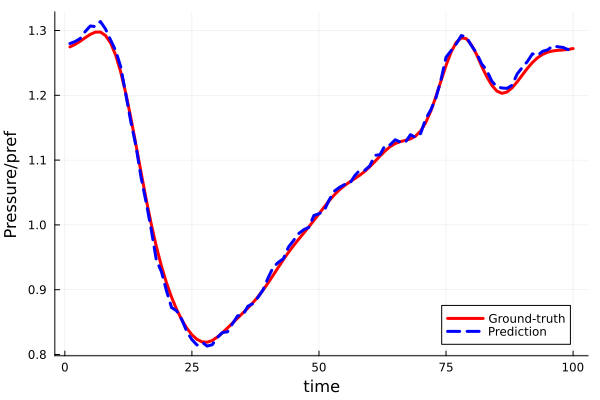

In [81]:
plot(ptrain[:,45,1], label = "Ground-truth", color=:red, linewidth = 3)
plot!(pred_train_mat_p[:,45,1], label = "Prediction", color=:blue, linewidth = 3,linestyle=:dash)
xlabel!("time")
ylabel!("Pressure/pref")

In [82]:
Atrain_base = maximum(mean(Atrain,dims=(1)),dims=2);
A_stenosis = minimum(Atrain,dims=(1,2));
Kv = 32 .* Ls .* Atrain_base.^2 ./ (A_stenosis.^2 .* 2 .*r0);
Re = ρ ./ν * (ytrain2 ./ Atrain_base) .* (2 .* r0);
Δp = Kt .* ρ .* ytrain2.^2 ./ (2 .* Atrain_base.^2) .* (Atrain_base./A_stenosis.-ones(size(Atrain_undef))).^2 + ρ .* ytrain2.^2 ./ Atrain_base .^2 .* Kv ./ Re;
Δp = Δp ./pref;
z = 1.4 : dz : L-1.4
p1 = pred_train_mat_p
mid_part = 31
batch = 81
M = size(pred_train_mat_p)[1]
tanh_elem = permutedims(tanh.(permutedims(repeat(10 .* p_pres[501:600],1,mid_part,batch),(2,1,3)) .* repeat((z.-2),1,M,batch)),(2,1,3));
a1 = repeat(mean(p1[:,1:35,:],dims=2),1,mid_part,1)
a2 = repeat(p1[:,62:62,:],1,mid_part,1)

# d = (a1 - a2)./2;
d = repeat(Δp[:,50:50,:],1,mid_part,1) ./ 2;
tanh_a = a1  .- d.* tanh_elem

part1 = repeat(tanh_a[:,1:1,:],1,mid_part+4,1);
part2 = repeat(tanh_a[:,end:end,:],1,mid_part+4,1);

p3 = cat(part1,tanh_a,part2,dims=2);

## Fit pressure residual ##

In [83]:
p_pres = ones(3 .* size(ptrain[:,1,1])) .+1e-5
p_pres[101:200] .= 1e-4
p_pres[201:204] .= 1e-5
ps_pres = deepcopy(p_pres)
pres_size = size(p_pres,1);
println("Number of parameters in pp vector for pressure equation: $pres_size"); 

Number of parameters in pp vector for pressure equation: 300


In [84]:
function loss_press_train_res(p_pres, Atrain, ptrain, Atrain_undef, ytrain, pref, ppred , Ehr,λ)
    batch = size(Atrain)[3]
    

    S_S0 = Atrain ./ Atrain_undef
    v = ytrain ./ Atrain
    Atrain_base = maximum(mean(Atrain,dims=(1)),dims=2);
    A_stenosis = minimum(Atrain,dims=(1,2));
    Kv = (32) .* Ls .* Atrain_base.^2 ./ (A_stenosis.^2 .* 2 .*r0);
    Re = ρ ./ν * (ytrain ./ Atrain_base) .* (2 .* r0);
    Δp = (Kt .+ p_pres[201])  .* ρ .* ytrain.^2 ./ (2 .* Atrain_base.^2) .* (Atrain_base./A_stenosis.-ones(size(Atrain_undef))).^2 + ρ .* ytrain.^2 ./ Atrain_base .^2 .* Kv ./ Re;
    Δp = Δp ./pref 

    mid_part = 31
    tanh_elem = permutedims(tanh.(permutedims(repeat(10 .* p_pres[1:100],1,mid_part,batch),(2,1,3)) .* repeat((z.-2),1,M,batch)),(1,2,3));

    a1 = repeat(mean(ppred[1:35,:,:],dims=1),mid_part,1,1).+ p_pres[203]



    d = (repeat(Δp[50:50,:,:],mid_part,1,1) .+ permutedims(repeat(p_pres[101:200],1,mid_part,batch),(2,1,3)) ) ./ 2;

    tanh_a = a1  .- d.* tanh_elem

    
    part1 = repeat(tanh_a[1:1,:,:],mid_part+4,1,1)
    part2 = repeat(tanh_a[end:end,:,:],mid_part+4,1,1)

    
    p3 = cat(part1,tanh_a,part2,dims=1);

    loss_rec = sum(abs2,p3[:,:,:] - ptrain[:,:,:])
    drop_pred = p3[40,:,:]-p3[55,:,:]
    drop_p = ptrain[40,:,:]-ptrain[55,:,:]
    loss_drop = sum(abs2, drop_pred - drop_p)
    
    
    loss = loss_rec 
    return loss, p3
end

loss_press_train_res (generic function with 1 method)

In [85]:
function loss_press_res(ps, Atrain, ptrain, Atrain_undef, ytrain, pref, ppred, Ehr,λ)
    batch = size(Atrain)[3]
    
    
    S_S0 = Atrain ./ Atrain_undef
    v = ytrain ./ Atrain
    Atrain_base = maximum(mean(Atrain,dims=(1)),dims=2);
    A_stenosis = minimum(Atrain,dims=(1,2));
    Kv = (32) .* Ls .* Atrain_base.^2 ./ (A_stenosis.^2 .* 2 .*r0);
    Re = ρ ./ν * (ytrain ./ Atrain_base) .* (2 .* r0);
    Δp = (Kt .+ p_pres[201]) .* ρ .* ytrain.^2 ./ (2 .* Atrain_base.^2) .* (Atrain_base./A_stenosis.-ones(size(Atrain_undef))).^2 + ρ .* ytrain.^2 ./ Atrain_base .^2 .* Kv ./ Re;
    Δp = Δp ./pref 

    mid_part = 31
    tanh_elem = permutedims(tanh.(permutedims(repeat(10 .* p_pres[1:100],1,mid_part,batch),(2,1,3)) .* repeat((z.-2),1,M,batch)),(1,2,3));

    a1 = repeat(mean(ppred[1:35,:,:],dims=1),mid_part,1,1) .+ p_pres[203]



    d =(repeat(Δp[50:50,:,:],mid_part,1,1) .+ permutedims(repeat(p_pres[101:200],1,mid_part,batch),(2,1,3)) ) ./ 2;


    tanh_a = a1  .- d.* tanh_elem

    
    part1 = repeat(tanh_a[1:1,:,:],mid_part+4,1,1)

    part2 = repeat(tanh_a[end:end,:,:],mid_part+4,1,1)

    
    p3 = cat(part1,tanh_a,part2,dims=1);

    loss_rec = sum(abs2,p3[:,:,:] - ptrain[:,:,:])

    loss_dpdz = 0.0
    
    drop_pred = p3[40,:,:]-p3[55,:,:]
    drop_p = ptrain[40,:,:]-ptrain[55,:,:]
    loss_drop = sum(abs2, drop_pred - drop_p) 
    
    loss = loss_rec .+ λ .* loss_dpdz 

    return loss, loss_dpdz, loss_rec, p3
end

loss_press_res (generic function with 1 method)

In [86]:
transfer_learning = true
if transfer_learning == false
    uinit_p = deepcopy(ps_pres);
    println("New training initialized!")
else
    p = load("/home/hunor/PhD/LANL/summer2024/dQdz_FourierSeries/p_res_trained_BFGS_p.jld2")
    uinit_p = p["p"]
    println("Parameters loaded from file!")
end

Parameters loaded from file!


In [87]:
n_epochs = 3
#set batch size
batch_size = 81
println("Batch size:", batch_size)
println("############################################")
#training batches
batch_iterations = Int(ceil(size(ptrain,3)/batch_size))
#testing batches
test_wave_batch_iterations = Int(ceil(size(ptest_wave,3)/batch_size));
test_geom_batch_iterations = Int(ceil(size(ptest_geom,3)/batch_size));

Batch size:81
############################################


In [88]:
list_loss_epoch = []
list_loss_test_wave = []
list_loss_epoch_test_wave = []
list_loss_test_geom = []
list_loss_epoch_test_geom = []

learning_rate = 1e-1;
λ = 0.0
for j in 1:n_epochs
    println("Start training epoch ",j)
    loss_tot = 0.0
    loss_tot_test_wave = 0.0
    loss_tot_test_geom = 0.0
    
    loss_tot_dpdz = 0.0
    loss_tot_test_wave_dpdz = 0.0
    loss_tot_test_geom_dpdz = 0.0
    
    loss_tot_rec = 0.0
    loss_tot_test_wave_rec = 0.0
    loss_tot_test_geom_rec = 0.0
        # loop over different waveforms
        for i in 1:batch_iterations

            println("waveform batch: ",i, "/",batch_iterations)
            flush(stdout)
            #reorder ytrain, atrain to [time, batch_size, spatial location]
            # batch size should be second column

            if i!=batch_iterations
                Ptrain = permutedims(ptrain[:,:,batch_size*(i-1)+1:batch_size*i],(2,1,3))
                ppred = permutedims(pred_train_mat_p[:,:,batch_size*(i-1)+1:batch_size*i],(2,1,3))
                ytrain = permutedims(pred_train_mat[:,batch_size*(i-1)+1:batch_size*i,1+skip_sides:end-skip_sides],(3,1,2))
                atrain = permutedims(Atrain[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:batch_size*i],(2,1,3))
                atrain_undef = permutedims(Atrain_undef[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:batch_size*i],(2,1,3))
            else
                Ptrain = permutedims(ptrain[:,:,batch_size*(i-1)+1:end],(2,1,3))
                ppred = permutedims(pred_train_mat_p[:,:,batch_size*(i-1)+1:end],(2,1,3))
                ytrain = permutedims(pred_train_mat[:,batch_size*(i-1)+1:end,1+skip_sides:end-skip_sides],(3,1,2))
                atrain = permutedims(Atrain[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:end],(2,1,3))
                atrain_undef = permutedims(Atrain_undef[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:end],(2,1,3))
            
            end

            if j == 120 && i==1
                global learning_rate = learning_rate * 0.1
                println("Changing ADAM learning rate to:",learning_rate)
                global λ = 1e3;
                println("Changing dp/dz loss lambda to:",λ)
            elseif j ==  101 && i==1
                global λ = 1e4;
                println("Changing dp/dz loss lambda to:",λ)
            end
        
        
            global optf_NN = Optimization.OptimizationFunction((uinit_p,x)->loss_press_train_res(uinit_p,atrain,Ptrain,atrain_undef,ytrain,pref,ppred,Ehr,λ),adtype);
            if j < 1

                global iters = 0 ;
                resnew = train_ADAM(uinit_p, optf_NN, learning_rate)
                global uinit_p = resnew.u
                jldsave("ptrained_ADAM_p.jld2",p=resnew.u)
                println("ADAM: Sum p pressure params:",sum(uinit_p))
            else
                global iters = 0 ;
                resnew = train_BFGS(uinit_p, optf_NN);
                global uinit_p = resnew.u
                jldsave("p_res_trained_BFGS_p.jld2",p=resnew.u)
                println("BFGS: Sum p pressure params:",sum(uinit_p))
            end
        
        
            loss_pres, loss_dpdz, loss_rec ,p_pred = loss_press_res(uinit_p, atrain, Ptrain, atrain_undef, ytrain, pref, ppred, Ehr,λ);
            loss_tot = loss_tot + loss_pres
            loss_tot_dpdz += loss_dpdz
            loss_tot_rec += loss_rec

        end
    
    
                        # loop over different waveforms
        for i in 1:test_wave_batch_iterations

            println("waveform batch: ",i, "/",test_wave_batch_iterations)
            flush(stdout)


            if i!=test_wave_batch_iterations
                Ptest = permutedims(ptest_wave[:,:,batch_size*(i-1)+1:batch_size*i],(2,1,3))
                ptest_pred = permutedims(pred_test_wave_mat_p[:,:,batch_size*(i-1)+1:batch_size*i],(2,1,3))
                ytest = permutedims(pred_test_wave_mat[:,batch_size*(i-1)+1:batch_size*i,1+skip_sides:end-skip_sides],(3,1,2))
                atest = permutedims(Atest_wave[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:batch_size*i],(2,1,3))
                atest_undef = permutedims(Atest_wave_undef[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:batch_size*i],(2,1,3))
            
                
            else
                Ptest = permutedims(ptest_wave[:,:,batch_size*(i-1)+1:end],(2,1,3))
                ptest_pred = permutedims(pred_test_wave_mat_p[:,:,batch_size*(i-1)+1:end],(2,1,3))
                ytest = permutedims(pred_test_wave_mat[:,batch_size*(i-1)+1:end,1+skip_sides:end-skip_sides],(3,1,2))
                atest = permutedims(Atest_wave[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:end],(2,1,3))
                atest_undef = permutedims(Atest_wave_undef[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:end],(2,1,3))
            
            end

        
            
            loss_pres, loss_dpdz, loss_rec ,p_pred = loss_press_res(uinit_p, atest, Ptest, atest_undef, ytest, pref, ptest_pred, Ehr,λ);
            loss_tot_test_wave = loss_tot_test_wave + loss_pres
            loss_tot_test_wave_dpdz += loss_dpdz
            loss_tot_test_wave_rec += loss_rec
            push!(pred_test_wave, p_pred)
        
        end
    
    
    
                    # loop over different waveforms
        for i in 1:test_geom_batch_iterations

            println("waveform batch: ",i, "/",test_geom_batch_iterations)
            flush(stdout)

            if i!=test_geom_batch_iterations
                Ptest = permutedims(ptest_geom[:,:,batch_size*(i-1)+1:batch_size*i],(2,1,3))
                ptest_pred = permutedims(pred_test_geom_mat_p[:,:,batch_size*(i-1)+1:batch_size*i],(2,1,3))
                ytest = permutedims(pred_test_geom_mat[:,batch_size*(i-1)+1:batch_size*i,1+skip_sides:end-skip_sides],(3,1,2))
                atest = permutedims(Atest_geom[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:batch_size*i],(2,1,3))
                atest_undef = permutedims(Atest_geom_undef[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:batch_size*i],(2,1,3))
            
            
            else
                Ptest = permutedims(ptest_geom[:,:,batch_size*(i-1)+1:end],(2,1,3))
                ptest_pred = permutedims(pred_test_geom_mat_p[:,:,batch_size*(i-1)+1:end],(2,1,3))
                ytest = permutedims(pred_test_geom_mat[:,batch_size*(i-1)+1:end,1+skip_sides:end-skip_sides],(3,1,2))
                atest = permutedims(Atest_geom[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:end],(2,1,3))
                atest_undef = permutedims(Atest_geom_undef[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:end],(2,1,3))
            
            
            end

            
            
            loss_pres, loss_dpdz, loss_rec ,p_pred = loss_press_res(uinit_p, atest, Ptest, atest_undef, ytest, pref, ptest_pred, Ehr, λ);
            loss_tot_test_geom = loss_tot_test_geom + loss_pres
            loss_tot_test_geom_dpdz += loss_dpdz
            loss_tot_test_geom_rec += loss_rec
            push!(pred_test_geom, p_pred)
        
        end
    
    # save and print losses
    push!(list_loss_epoch, loss_tot/(size(ptrain,3)))
    push!(list_loss_epoch_test_wave, loss_tot_test_wave/(size(ptest_wave,3)))
    push!(list_loss_epoch_test_geom, loss_tot_test_geom/(size(ptest_geom,3)))
    println("Epoch ", j, " mean train loss:", loss_tot/(size(ptrain,3)))
    println("Epoch ", j, " mean train rec loss:", loss_tot_rec/(size(ptrain,3)))
    println("Epoch ", j, " mean train dpdz loss:", loss_tot_dpdz/(size(ptrain,3)))
    println("Epoch ", j, " mean test loss - new waveform:", loss_tot_test_wave/(size(ptest_wave,3)))
    println("Epoch ", j, " mean test loss  rec - new waveform:", loss_tot_test_wave_rec/(size(ptest_wave,3)))
    println("Epoch ", j, " mean test loss dpdz - new waveform:", loss_tot_test_wave_dpdz/(size(ptest_wave,3)))

    println("Epoch ", j, " mean test loss - new geom:", loss_tot_test_geom/(size(ptest_geom,3)))
    println("Epoch ", j, " mean test loss rec new geom:", loss_tot_test_geom_rec/(size(ptest_geom,3)))
    println("Epoch ", j, " mean test loss dpdz new geom:", loss_tot_test_geom_dpdz/(size(ptest_geom,3)))
    
end

Start training epoch 1
waveform batch: 1/1
Iteration: 1 || Loss: 36.10169521484029
Iteration: 2 || Loss: 36.10133067121929
Iteration: 3 || Loss: 36.10130796640871
Iteration: 4 || Loss: 36.10126649684067
Iteration: 5 || Loss: 36.10108337829196
Iteration: 6 || Loss: 36.101083320723575
Iteration: 7 || Loss: 36.101083320718246
Iteration: 8 || Loss: 36.10108332058569
Iteration: 9 || Loss: 36.10108306356038
Iteration: 10 || Loss: 36.10108302460284
Iteration: 11 || Loss: 36.10108302460078
Iteration: 12 || Loss: 36.101083024600314
Iteration: 13 || Loss: 36.10108302380655
Iteration: 14 || Loss: 36.101082917929766
Iteration: 15 || Loss: 36.10108291702667
Iteration: 16 || Loss: 36.101082917023675
Iteration: 17 || Loss: 36.101082917023504
Iteration: 18 || Loss: 36.10108291606349
Iteration: 19 || Loss: 36.10108289054263
Iteration: 20 || Loss: 36.10108288874181
Iteration: 21 || Loss: 36.10108288874167
Iteration: 22 || Loss: 36.10108288874123
Iteration: 23 || Loss: 36.10108288859035
Iteration: 24 || 

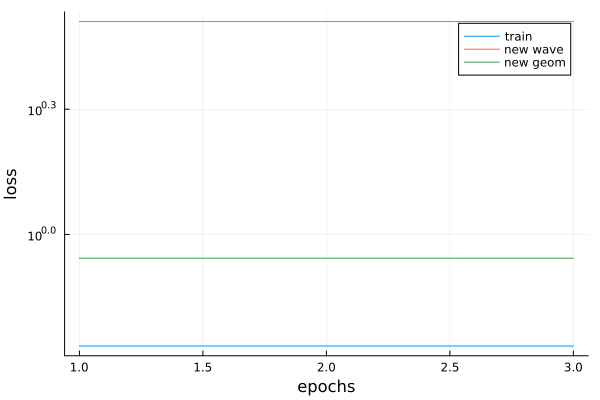

In [89]:
### plot loss as a function of epochs
p3 = plot([list_loss_epoch,list_loss_epoch_test_wave,list_loss_epoch_test_geom], yaxis=:log, label = ["train" "new wave" "new geom"])
ylabel!("loss")
xlabel!("epochs")
display(p3)

In [90]:
list_loss_epoch = []
list_loss_test_wave = []
list_loss_epoch_test_wave = []
list_loss_test_geom = []
list_loss_epoch_test_geom = []

learning_rate = 1e-1;
λ = 0.0

pred_train = []
pred_test_wave = []
pred_test_geom = []

for j in 1:1
    println("Start training epoch ",j)
    loss_tot = 0.0
    loss_tot_test_wave = 0.0
    loss_tot_test_geom = 0.0
    
    loss_tot_dpdz = 0.0
    loss_tot_test_wave_dpdz = 0.0
    loss_tot_test_geom_dpdz = 0.0
    
    loss_tot_rec = 0.0
    loss_tot_test_wave_rec = 0.0
    loss_tot_test_geom_rec = 0.0
        # loop over different waveforms
        for i in 1:batch_iterations

            println("waveform batch: ",i, "/",batch_iterations)
            flush(stdout)
            #reorder ytrain, atrain and dAdz to [time, batch_size, spatial location]
            # batch size should be second column

            if i!=batch_iterations
                Ptrain = permutedims(ptrain[:,:,batch_size*(i-1)+1:batch_size*i],(2,1,3))
                ppred = permutedims(pred_train_mat_p[:,:,batch_size*(i-1)+1:batch_size*i],(2,1,3))
                ytrain = permutedims(pred_train_mat[:,batch_size*(i-1)+1:batch_size*i,1+skip_sides:end-skip_sides],(3,1,2))
                atrain = permutedims(Atrain[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:batch_size*i],(2,1,3))
                atrain_undef = permutedims(Atrain_undef[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:batch_size*i],(2,1,3))
            else
                Ptrain = permutedims(ptrain[:,:,batch_size*(i-1)+1:end],(2,1,3))
                ppred = permutedims(pred_train_mat_p[:,:,batch_size*(i-1)+1:end],(2,1,3))
                ytrain = permutedims(pred_train_mat[:,batch_size*(i-1)+1:end,1+skip_sides:end-skip_sides],(3,1,2))
                atrain = permutedims(Atrain[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:end],(2,1,3))
                atrain_undef = permutedims(Atrain_undef[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:end],(2,1,3))
            
            end
        
            loss_pres, loss_dpdz, loss_rec ,p_pred = loss_press_res(uinit_p, atrain, Ptrain, atrain_undef, ytrain, pref, ppred, Ehr,λ);
            loss_tot = loss_tot + loss_pres
            loss_tot_dpdz += loss_dpdz
            loss_tot_rec += loss_rec
            push!(pred_train, p_pred)

        end
    
    
                        # loop over different waveforms
        for i in 1:test_wave_batch_iterations

            println("waveform batch: ",i, "/",test_wave_batch_iterations)
            flush(stdout)


            if i!=test_wave_batch_iterations
                Ptest = permutedims(ptest_wave[:,:,batch_size*(i-1)+1:batch_size*i],(2,1,3))
                ptest_pred = permutedims(pred_test_wave_mat_p[:,:,batch_size*(i-1)+1:batch_size*i],(2,1,3))
                ytest = permutedims(pred_test_wave_mat[:,batch_size*(i-1)+1:batch_size*i,1+skip_sides:end-skip_sides],(3,1,2))
                atest = permutedims(Atest_wave[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:batch_size*i],(2,1,3))
                atest_undef = permutedims(Atest_wave_undef[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:batch_size*i],(2,1,3))
            
                
            else
                Ptest = permutedims(ptest_wave[:,:,batch_size*(i-1)+1:end],(2,1,3))
                ptest_pred = permutedims(pred_test_wave_mat_p[:,:,batch_size*(i-1)+1:end],(2,1,3))
                ytest = permutedims(pred_test_wave_mat[:,batch_size*(i-1)+1:end,1+skip_sides:end-skip_sides],(3,1,2))
                atest = permutedims(Atest_wave[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:end],(2,1,3))
                atest_undef = permutedims(Atest_wave_undef[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:end],(2,1,3))
            
            end

        
            
            loss_pres, loss_dpdz, loss_rec ,p_pred = loss_press_res(uinit_p, atest, Ptest, atest_undef, ytest, pref, ptest_pred, Ehr, λ);;
            loss_tot_test_wave = loss_tot_test_wave + loss_pres
            loss_tot_test_wave_dpdz += loss_dpdz
            loss_tot_test_wave_rec += loss_rec
            push!(pred_test_wave, p_pred)
        
        end
    
    
    
                    # loop over different waveforms
        for i in 1:test_geom_batch_iterations

            println("waveform batch: ",i, "/",test_geom_batch_iterations)
            flush(stdout)

            if i!=test_geom_batch_iterations
                Ptest = permutedims(ptest_geom[:,:,batch_size*(i-1)+1:batch_size*i],(2,1,3))
                ptest_pred = permutedims(pred_test_geom_mat_p[:,:,batch_size*(i-1)+1:batch_size*i],(2,1,3))
                ytest = permutedims(pred_test_geom_mat[:,batch_size*(i-1)+1:batch_size*i,1+skip_sides:end-skip_sides],(3,1,2))
                atest = permutedims(Atest_geom[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:batch_size*i],(2,1,3))
                atest_undef = permutedims(Atest_geom_undef[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:batch_size*i],(2,1,3))
            
            
            else
                Ptest = permutedims(ptest_geom[:,:,batch_size*(i-1)+1:end],(2,1,3))
                ptest_pred = permutedims(pred_test_geom_mat_p[:,:,batch_size*(i-1)+1:end],(2,1,3))
                ytest = permutedims(pred_test_geom_mat[:,batch_size*(i-1)+1:end,1+skip_sides:end-skip_sides],(3,1,2))
                atest = permutedims(Atest_geom[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:end],(2,1,3))
                atest_undef = permutedims(Atest_geom_undef[:,1+skip_sides:end-skip_sides,batch_size*(i-1)+1:end],(2,1,3))
            
            
            end

            
            
            loss_pres, loss_dpdz, loss_rec ,p_pred = loss_press_res(uinit_p, atest, Ptest, atest_undef, ytest, pref, ptest_pred, Ehr, λ);
            loss_tot_test_geom = loss_tot_test_geom + loss_pres
            loss_tot_test_geom_dpdz += loss_dpdz
            loss_tot_test_geom_rec += loss_rec
            push!(pred_test_geom, p_pred)
        

        end
    
    # save and print losses
    push!(list_loss_epoch, loss_tot/(size(ptrain,3)))
    push!(list_loss_epoch_test_wave, loss_tot_test_wave/(size(ptest_wave,3)))
    push!(list_loss_epoch_test_geom, loss_tot_test_geom/(size(ptest_geom,3)))
    println("Epoch ", j, " mean train loss:", loss_tot/(size(ptrain,3)))
    println("Epoch ", j, " mean train rec loss:", loss_tot_rec/(size(ptrain,3)))
    println("Epoch ", j, " mean train dpdz loss:", loss_tot_dpdz/(size(ptrain,3)))
    println("Epoch ", j, " mean test loss - new waveform:", loss_tot_test_wave/(size(ptest_wave,3)))
    println("Epoch ", j, " mean test loss  rec - new waveform:", loss_tot_test_wave_rec/(size(ptest_wave,3)))
    println("Epoch ", j, " mean test loss dpdz - new waveform:", loss_tot_test_wave_dpdz/(size(ptest_wave,3)))

    println("Epoch ", j, " mean test loss - new geom:", loss_tot_test_geom/(size(ptest_geom,3)))
    println("Epoch ", j, " mean test loss rec new geom:", loss_tot_test_geom_rec/(size(ptest_geom,3)))
    println("Epoch ", j, " mean test loss dpdz new geom:", loss_tot_test_geom_dpdz/(size(ptest_geom,3)))
    
end

Start training epoch 1
waveform batch: 1/1
waveform batch: 1/1
waveform batch: 1/1
Epoch 1 mean train loss:0.5402727883168216
Epoch 1 mean train rec loss:0.5402727883168216
Epoch 1 mean train dpdz loss:0.0
Epoch 1 mean test loss - new waveform:3.2364475263046475
Epoch 1 mean test loss  rec - new waveform:3.2364475263046475
Epoch 1 mean test loss dpdz - new waveform:0.0
Epoch 1 mean test loss - new geom:0.8771292179342801
Epoch 1 mean test loss rec new geom:0.8771292179342801
Epoch 1 mean test loss dpdz new geom:0.0


In [91]:
println("Kt learned:",uinit_p[201])
println("Kv param learned:",uinit_p[202])

Kt learned:-0.33833876160973164
Kv param learned:1.0e-5


In [92]:
#reshape prediction matrix
pred_train_mat_pres = zero(ptrain);
pred_test_wave_mat_pres = zero(ptest_wave);
pred_test_geom_mat_pres = zero(ptest_geom);

for i in range(1,size(pred_train)[1])
    if i==size(pred_train)[1]
        pred_train_mat_pres[:,:,batch_size*(i-1)+1:end] = permutedims(pred_train[i],(2,1,3)) 
    else
        pred_train_mat_pres[:,:,batch_size*(i-1)+1:batch_size*i] = permutedims(pred_train[i],(2,1,3)) 
    end
end


for i in range(1,size(pred_test_wave)[1])
    if i==size(pred_test_wave)[1]
        pred_test_wave_mat_pres[:,:,batch_size*(i-1)+1:end] = permutedims(pred_test_wave[i],(2,1,3)) 
    else
        pred_test_wave_mat_pres[:,:,batch_size*(i-1)+1:batch_size*i] = permutedims(pred_test_wave[i],(2,1,3)) 
    end
end


for i in range(1,size(pred_test_geom)[1])
    if i==size(pred_test_geom)[1]
        pred_test_geom_mat_pres[:,:,batch_size*(i-1)+1:end] = permutedims(pred_test_geom[i],(2,1,3)) 
    else
        pred_test_geom_mat_pres[:,:,batch_size*(i-1)+1:batch_size*i] = permutedims(pred_test_geom[i],(2,1,3))
    end
end

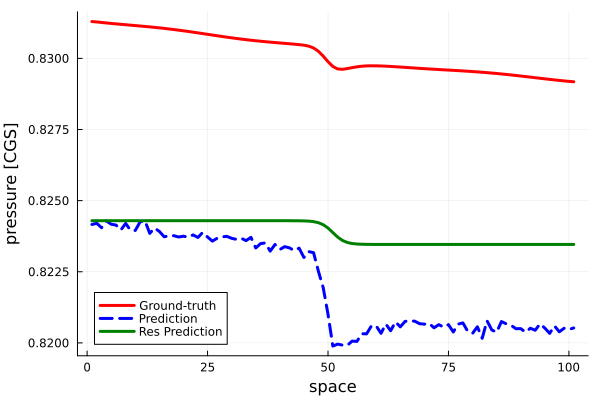

In [93]:
wf = 1
plot((ptrain)[25,:,wf],label = "Ground-truth", color=:red, linewidth = 3)
plot!((pred_train_mat_p)[25,:,wf], label = "Prediction", color=:blue, linewidth = 3,linestyle=:dash)
plot!(pred_train_mat_pres[25,:,wf],label = "Res Prediction", color=:green, linewidth = 3,linestyle=:solid)
xlabel!("space")
ylabel!("pressure [CGS]")

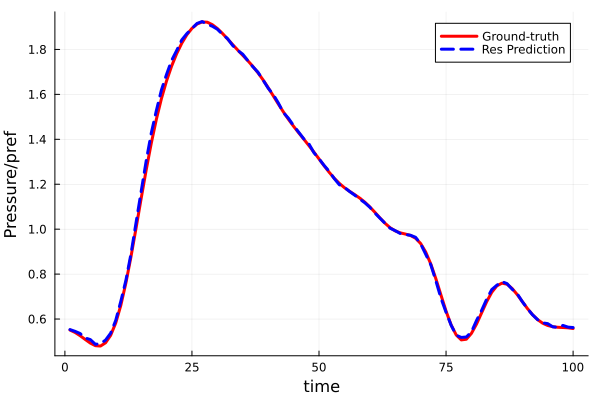

In [94]:
wf = 72
plot(ptrain[:,90,wf], label = "Ground-truth", color=:red, linewidth = 3)
# plot!(pred_train_mat_p[:,90,wf], label = "Prediction", color=:blue, linewidth = 3,linestyle=:dash)
plot!(pred_train_mat_pres[:,90,wf],label = "Res Prediction", color=:blue, linewidth = 3,linestyle=:dash)
xlabel!("time")
ylabel!("Pressure/pref")

In [95]:
Atrain_base = maximum(mean(Atrain_org,dims=(1)),dims=2);
# A_stenosis = minimum(Atrain,dims=(1,2));
A_stenosis = minimum(Atrain_org,dims=(1,2));
Kv = 32 .* Ls .* Atrain_base.^2 ./ (A_stenosis.^2 .* 2 .*r0);
Re = ρ ./ν * (ytrain2 ./ Atrain_base) .* (2 .* r0);
Δp = Kt .* ρ .* ytrain2.^2 ./ (2 .* Atrain_base.^2) .* (Atrain_base./A_stenosis.-ones(size(Atrain_undef))).^2 + ρ .* ytrain2.^2 ./ Atrain_base .^2 .* Kv ./ Re;
Δp = Δp ./pref;

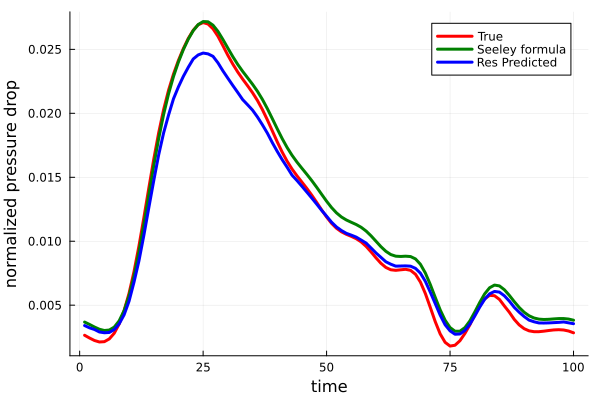

In [96]:
wf = 72
plot(ptrain[:,40,wf] -ptrain[:,55,wf], label = "True",linewidth = 3, color =:red)
plot!(Δp[:,50,wf], label = "Seeley formula",linewidth = 3, color=:green)
# plot!(pred_train_mat_p[:,40,wf] - pred_train_mat_p[:,55,wf], label = "Predicted", linewidth = 3)
plot!(pred_train_mat_pres[:,40,wf] - pred_train_mat_pres[:,55,wf],label = "Res Predicted", linewidth = 3, color=:blue)
xlabel!("time")
ylabel!("normalized pressure drop")

In [97]:
Atest_wave_base = maximum(mean(Atest_wave_org,dims=(1)),dims=2);
# A_stenosis = minimum(Atrain,dims=(1,2));
A_stenosis = minimum(Atest_wave_org,dims=(1,2));
Kv = 32 .* Ls .* Atest_wave_base.^2 ./ (A_stenosis.^2 .* 2 .*r0);
Re = ρ ./ν * (ytest_wave ./ Atest_wave_base) .* (2 .* r0);
Δp_wave = Kt .* ρ .* ytest_wave.^2 ./ (2 .* Atest_wave_base.^2) .* (Atest_wave_base./A_stenosis.-ones(size(Atest_wave_undef))).^2 + ρ .* ytest_wave.^2 ./ Atest_wave_base .^2 .* Kv ./ Re;
Δp_wave = Δp_wave ./pref;

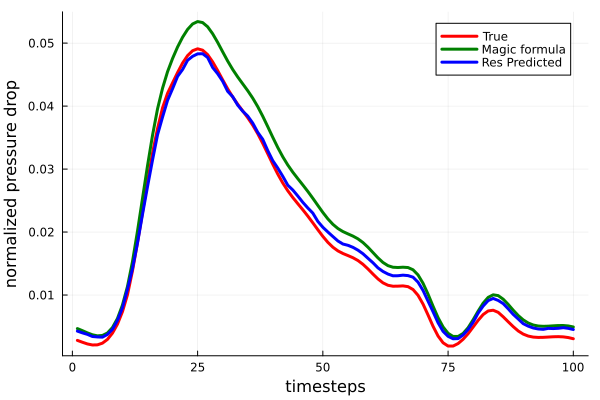

In [98]:
wf = 9
plot(ptest_wave[:,40,wf] -ptest_wave[:,60,wf], label = "True",linewidth = 3, color=:red)
plot!(Δp_wave[:,50,wf], label = "Magic formula",linewidth = 3, color=:green)
# plot!(pred_test_wave_mat_p[:,40,wf] - pred_test_wave_mat_p[:,55,wf], label = "Predicted")
plot!(pred_test_wave_mat_pres[:,40,wf] - pred_test_wave_mat_pres[:,60,wf],label = "Res Predicted",linewidth = 3, color=:blue)
xlabel!("timesteps")
ylabel!("normalized pressure drop")

In [99]:
Atest_geom_base = maximum(mean(Atest_geom_org,dims=(1)),dims=2);

A_stenosis = minimum(Atest_geom_org,dims=(1,2));
Kv = 32 .* Ls .* Atest_geom_base.^2 ./ (A_stenosis.^2 .* 2 .*r0);
Re = ρ ./ν * (ytest_geom ./ Atest_geom_base) .* (2 .* r0);
Δp_geom = Kt .* ρ .* ytest_geom.^2 ./ (2 .* Atest_geom_base.^2) .* (Atest_geom_base./A_stenosis.-ones(size(Atest_geom_undef))).^2 + ρ .* ytest_geom.^2 ./ Atest_geom_base .^2 .* Kv ./ Re;
Δp_geom = Δp_geom ./pref;

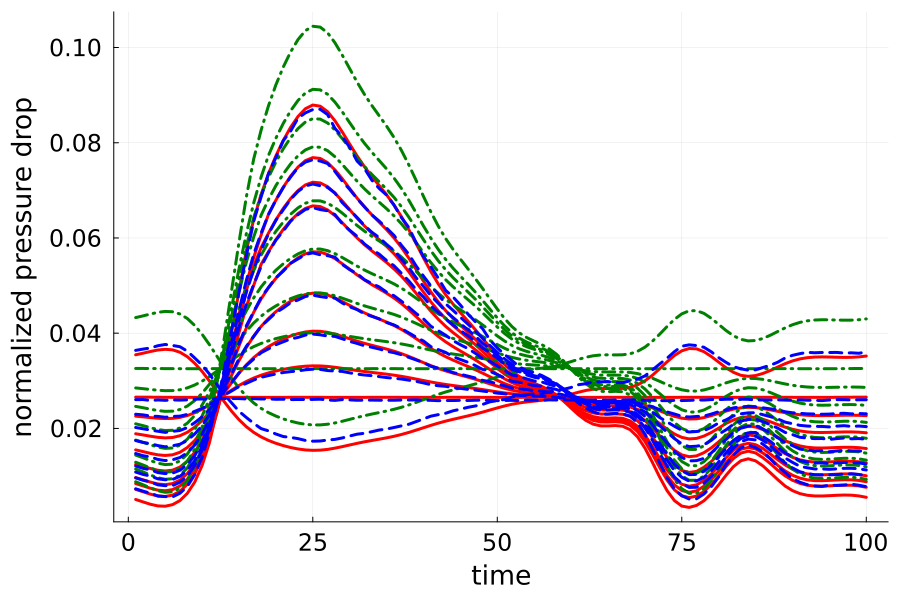

In [100]:
wf = 1:10
plot(ptest_geom[:,40,wf] -ptest_geom[:,60,wf], label = "",linewidth = 3, color=:red)
plot!(Δp_geom[:,50,wf], label = "",linewidth = 3, color=:green, linestyle=:dashdot,yguidefontsize=18,legendfontsize=18,xguidefontsize=18)
# plot!(pred_test_wave_mat_p[:,40,wf] - pred_test_wave_mat_p[:,55,wf], label = "Predicted")
plot!(pred_test_geom_mat_pres[:,40,wf] - pred_test_geom_mat_pres[:,60,wf],label = "",linewidth = 3, color=:blue, linestyle=:dash)
xlabel!("time", xtickfontsize=16,ytickfontsize=16,left_margin=5Plots.mm,bottom_margin=5Plots.mm)
plot!(size=(900,600))
ylabel!("normalized pressure drop")
# savefig("../paper_figs/test_Deltap_vsSeeley_t.svg")

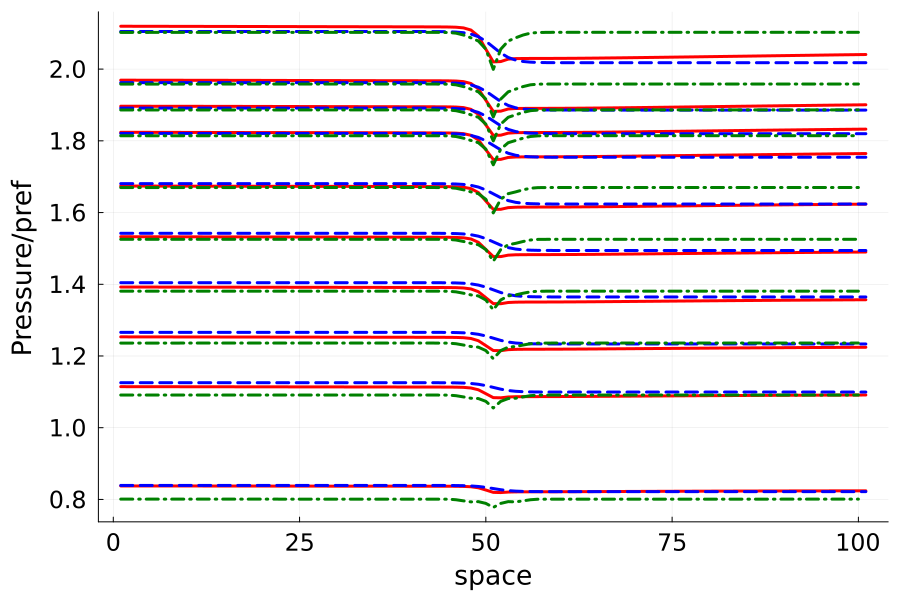

In [101]:
wf = 1:10
plot((ptest_geom)[25,:,wf],label = "", color=:red, linewidth = 3)
# plot!((pred_test_geom_mat_p)[25,:,wf], label = "Prediction", color=:blue, linewidth = 3,linestyle=:dash)
plot!(pred_test_geom_mat_pres[25,:,wf],label = "", color=:blue, linewidth = 3,linestyle=:dash)
plot!(data1d_fix[25,1:4:end,wf,2]./pref,label = "", color=:green, linewidth = 3,linestyle=:dashdot,yguidefontsize=18,legendfontsize=18,xguidefontsize=18)
xlabel!("space", xtickfontsize=16,ytickfontsize=16,left_margin=5Plots.mm,bottom_margin=5Plots.mm)
plot!(size=(900,600))
ylabel!("Pressure/pref")

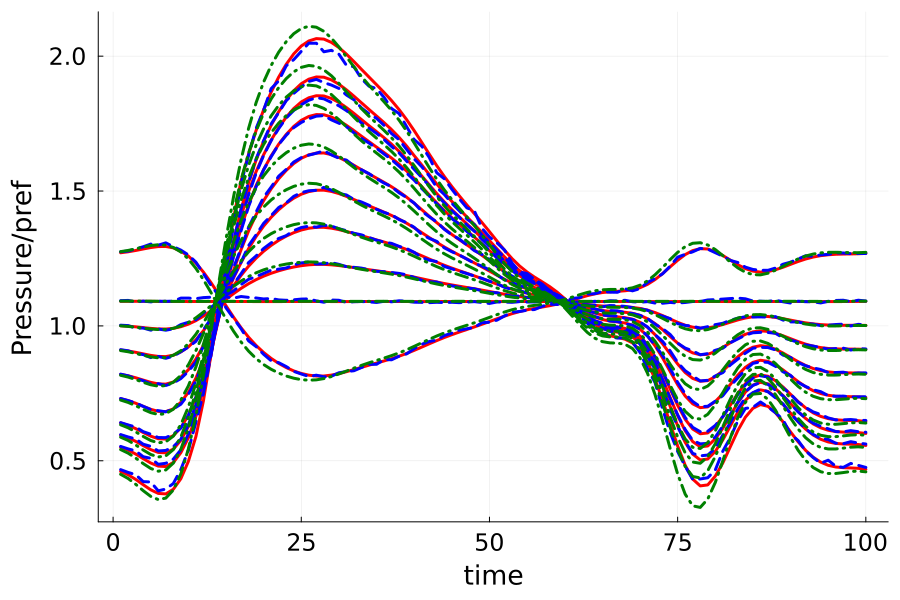

In [102]:
wf = 1:10
xpos = 90
plot(ptest_geom[:,xpos,wf], label = "", color=:red, linewidth = 3)
# plot!(pred_test_geom_mat_p[:,xpos,wf], label = "Prediction", color=:blue, linewidth = 3,linestyle=:dash)
plot!(pred_test_geom_mat_pres[:,xpos,wf],label = "", color=:blue, linewidth = 3,linestyle=:dash)
plot!(data1d_fix[:,xpos*4,wf,2]./pref,label = "", color=:green, linewidth = 3,linestyle=:dashdot,yguidefontsize=18,legendfontsize=18,xguidefontsize=18)
xlabel!("time", xtickfontsize=16,ytickfontsize=16,left_margin=5Plots.mm,bottom_margin=5Plots.mm)
plot!(size=(900,600))
ylabel!("Pressure/pref")

In [114]:
pres_err_train_node = norm(pred_train_mat_pres[:,1:end, 1:end] - ptrain[:,1:end, 1:end]) / norm(ptrain[:,1:end, 1:end])
print("PCNDE pressure prediction relative error - training: ", pres_err_train_node ,"\n")

PCNDE pressure prediction relative error - training: 0.006452780089833178


In [104]:
pred_pres_test = cat(pred_test_geom_mat_pres[:,1:end, 1:10],pred_test_wave_mat_pres[:,1:end, 1:end],dims=3);
pres_test = cat(ptest_geom[:,1:end, 1:10],ptest_wave[:,1:end, 1:end],dims=3);


pres_err_1d = norm(data1d_fix[:,1:4:end,1:end,2]./pref - pres_test[:,1:end-1, 1:end]) / norm(pres_test[:,1:end-1, 1:end])
println("1D FEM pressure prediction relative error: ", pres_err_1d)

pres_err_test_node = norm(pred_pres_test[:,1:end, 1:end] - pres_test[:,1:end, 1:end]) / norm(pres_test[:,1:end, 1:end])

println("PCNDE pressure prediction relative error - test: ", pres_err_test_node ,"\n")

1D FEM pressure prediction relative error: 0.036524740839696264
PCNDE pressure prediction relative error - test: 0.011753316923164937



In [105]:
err_train_p  = zeros(size(ptrain)[3])
max_err_train_p = 0.0
max_ID_train_p = 0.0
for i in range(1,size(ptrain)[3])
   err_train_p[i] = norm(pred_train_mat_pres[:,:,i] - ptrain[:,:,i]) ./ norm(ptrain[:,:,i])
   if err_train_p[i] > max_err_train_p
        max_err_train_p = err_train_p[i]
        max_ID_train_p = i
   end
end
println("Max p error training ID:",max_ID_train_p)
println("Max p error training:",max_err_train_p)


err_wave_p  =zeros(size(ptest_wave)[3])
max_err_wave_p = 0.0
max_ID_wave_p = 0.0
for i in range(1,size(ptest_wave)[3])
   err_wave_p[i] = norm(pred_test_wave_mat_pres[:,:,i] - ptest_wave[:,:,i]) ./ norm(ptest_geom[:,:,i])
   if err_wave_p[i] > max_err_wave_p
        max_err_wave_p = err_wave_p[i]
        max_ID_wave_p = i
   end
end
println("Max p error ID - test, new waveform:",max_ID_wave_p)
println("Max p error - test, new waveform:",max_err_wave_p)



err_geom_p  =zeros(size(ptest_geom)[3])
max_err_geom_p = 0.0
max_ID_geom_p = 0.0
for i in range(1,size(ptest_geom)[3])
   err_geom_p[i] = norm(pred_test_geom_mat_pres[:,:,i] - ptest_geom[:,:,i]) ./ norm(ptest_geom[:,:,i])
   if err_geom_p[i] > max_err_geom_p
        max_err_geom_p = err_geom_p[i]
        max_ID_geom_p = i
   end
end
println("Max p error ID - test, new stenosis:",max_ID_geom_p)
println("Max p error - test, new stenosis:",max_err_geom_p)

Max p error training ID:72
Max p error training:0.010586836781919077
Max p error ID - test, new waveform:5
Max p error - test, new waveform:0.016799953518144523
Max p error ID - test, new stenosis:10
Max p error - test, new stenosis:0.015183740484371279


In [106]:
main_block_p = hcat(reshape(err_train_p[1:end],(9,9))',err_wave_p[1:end])
last_row_p = reshape(err_geom_p[1:end],(1,10))
error_matrix_p = vcat(main_block_p,last_row_p);

In [120]:
# gr()
# heatmap(error_matrix_p, yflip=true)
# plot!(Shape([0.5, 0.5, 9.5, 9.5], [0.5, 9.5, 9.5,0.5]), label = "", fillcolor=:transparent, linecolor=:black, linewidth = 2)
# xlabel!("waveforms")
# ylabel!("geometries")
# # savefig("../paper_figs/p_error_matrix.svg")
# title!("Pressure error")

In [121]:
# gr()
# wf = 10
# h2 = heatmap(pred_test_geom_mat_pres[:,:,wf]',color=:viridis)
# ylabel!("space")
# title!("pressure predicted")
# h1 = heatmap(ptest_geom[:,:,wf]',color=:viridis)
# ylabel!("space")
# title!("p - ground truth")
# h3 = heatmap(abs.(pred_test_geom_mat_pres[:,:,wf]' - ptest_geom[:,:,wf]'), color=:viridis)
# ylabel!("space")
# xlabel!("time")
# title!("Absolute error")
# plot!(size=(700,900))
# display(plot(h1,h2,h3,layout=(3,1)))


In [109]:
big_Vec_p = reshape(pred_pres_test[:,1:end-1,1:end],(1,:))
big_Vec_GT_p = reshape(pres_test[:,1:end-1,1:end],(1,:))
        big_Vec_1D_p = reshape(data1d_fix[:,1:4:end,:,2],(1,:))./pref;

rel_err_1D_p = abs.(big_Vec_1D_p[rand_indices].-big_Vec_GT_p[rand_indices])./(big_Vec_GT_p[rand_indices]);
rel_err_NDE_p = abs.(big_Vec_p[rand_indices].-big_Vec_GT_p[rand_indices])./(big_Vec_GT_p[rand_indices]);

In [110]:
data_matrix_err = hcat(rel_err_1D, rel_err_NDE, rel_err_1D_S, rel_err_NDE_S, rel_err_1D_p, rel_err_NDE_p)

# Define the labels
labels = ["1D - Q", "PCNDE - Q", "1D - S", "PCNDE - S", "1D - p", "PCNDE - p"]

# Create the box plot with custom x-axis labels
boxplot(data_matrix_err,     xticks=(1:6, labels),    # Set custom x-axis labels
    fillcolor=:white,          # Set box color
    markercolor=:black,         # Set mean marker color to red
    marker=:circle,          # Set mean marker shape
    markersize=4,             # Set mean marker size
    legend=false,              # Disable legend
    linewidth = 2,
)
ylabel!("Relative pointwise error")
# savefig("../paper_figs/error_box_plots.svg")